## Based on CRTS_sel_g_cut_vs_r_cut.ipynb,   taking only the code needed to make Fig. 2 

A testbed for making Fig.2 :  the 4-panel plot.  The 4-panel plot shows the problem :  how we can't get anything meaningful if we plot various characteristics of uncorrected data. Thus there is no reason to do splitting into magnitude bins, correcting, etc - it's not the purpose here. 

The desired magnitude range for the paper is 18.5-19 

In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import datetime
from astroML.stats import median_sigmaG
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit

import CRTS_paper_modules as mod
import imp
imp.reload(mod)
#reload(mod)

<module 'CRTS_paper_modules' from '/Users/chris/GradResearch/CRTS_PROJECT/code/CRTS_paper_modules.py'>

In [8]:
cols1,  qso_cat = mod.get_qso_catalog() 
cols2 , star_cat= mod.get_stars_catalog()

Zipping CRTS-SDSS quasars catalog from ../data_products/CRTS_SDSS_catalogs/CRTS_SDSS_cross_matched_qso_DB_QSO_catalog.txt
Read in 7601 quasars from CRTS
zipping CRTS-SDSS stars catalog...
Read in catalog for 48250 stars from CRTS 


In [44]:
Min = 18.5
Max = 19

mag = 'r'

print('\nUsing now only lightcurves with SDSS  %f< %s < %f' % (Min, mag, Max))
print('\n Reporting SDSS %s  '% mag)

good_ids_S_blue = mod.cut_stars(star_cat = star_cat,mMin = Min, mMax=Max, mErrMax = 0.3, 
                                gi_Min = -1,
                                          gi_Max=1, cut_mag=mag + '_mMed')

good_ids_S_red = mod.cut_stars(star_cat = star_cat,mMin = Min, mMax=Max, mErrMax = 0.3, 
                               gi_Min = 1, 
                                       gi_Max=3, cut_mag=mag + '_mMed' )

good_ids_QSO = mod.cut_qso(qso_cat=qso_cat, mMin = Min, mMax=Max, mErrMax = 0.3, 
                                           cut_mag=mag)



Using now only lightcurves with SDSS  18.500000< r < 19.000000

 Reporting SDSS r  

Choosing stars with  SDSS   -1.00<g-i<1.00
 These cuts reduced the number of stars  in the sample from 48250 to 1496

Choosing stars with  SDSS   1.00<g-i<3.00
 These cuts reduced the number of stars  in the sample from 48250 to 2327

 Returning only QSO with  an SDSS counterpart within 2.000000 arcsec

 These cuts reduced the number of qso  in the sample from 7601 to 747


### Aside : comparing different reading algorithms 

In [40]:
# Compare reading the xi, ei : are they really the same ? 
# Given QSO ids to read ... 
# I select mags 16.9-17, so that there is just a 
# few QSO to read and the comparison is fast ... 

Min = 16.9
Max = 17

mag = 'r'

print('\nUsing now only lightcurves with SDSS  %f< %s < %f' % (Min, mag, Max))
print('\n Reporting SDSS %s  '% mag)

good_ids_S_blue = mod.cut_stars(star_cat = star_cat,mMin = Min, mMax=Max, mErrMax = 0.3, 
                                gi_Min = -1,
                                          gi_Max=1, cut_mag=mag + '_mMed')

good_ids_QSO = mod.cut_qso(qso_cat=qso_cat, mMin = Min, mMax=Max, mErrMax = 0.3, 
                                           cut_mag=mag)



result = mod.faster_read_xi_ei(inDirSF = inDirQSO,good_ids = good_ids_QSO )
qso_xi_faster = result['xi']

result = mod.fast_read_xi_ei(good_ids_QSO = good_ids_QSO)
qso_xi_fast = result['qso'][0] 

result = mod.read_xi_ei(inDirStars, good_ids_S_blue, inDirQSO,
                 good_ids_QSO)
qso_xi_old   = result[0][0] 


# These all should be equal to length of 
# all delta_mag points ... 
print(np.sum(np.in1d(qso_xi_faster, qso_xi_fast)))
print(np.sum(np.in1d(qso_xi_fast, qso_xi_old)))


Reading in tau,xi,ei  for 7 objects

Using structure function master files from ../data_products/sf_file_per_LC/qso/
[#######   ] 71.43%
Finished reading all master files for the selected objects ...

Reading in tau,xi,ei for  qso
[#######   ] 71.43%
Finished reading all master files for the selected objects ...
making new delflx, tau, xi arrays


Reading in quasars...
Returning delta_time in observed frame, t_obs
[#######   ] 71.43%

Reading in blue stars ...
[##########] 100.00%



## Read the xi, ei for objects in the r_cut ... 

In [45]:
inDirStars   = '../data_products/sf_file_per_LC/stars/'
inDirQSO = '../data_products/sf_file_per_LC/qso/'

out_dic = {}

# read the simple way , no need to do the generic read ... 
out_dic['qso'] = mod.faster_read_xi_ei(inDirSF = inDirQSO,
                                       good_ids = good_ids_QSO )
out_dic['starsB'] = mod.faster_read_xi_ei(inDirSF = inDirStars,
                                          good_ids = good_ids_S_blue )
out_dic['starsR'] = mod.faster_read_xi_ei(inDirSF = inDirStars,
                                          good_ids = good_ids_S_red )



Reading in tau,xi,ei  for 747 objects

Using structure function master files from ../data_products/sf_file_per_LC/qso/
[######### ] 99.73%
Finished reading all master files for the selected objects ...

Reading in tau,xi,ei  for 1496 objects

Using structure function master files from ../data_products/sf_file_per_LC/stars/
[######### ] 99.93%
Finished reading all master files for the selected objects ...

Reading in tau,xi,ei  for 2327 objects

Using structure function master files from ../data_products/sf_file_per_LC/stars/
[######### ] 99.91%
Finished reading all master files for the selected objects ...


### Aside: Plot the raw data ... 

/Users/chris/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:40: RuntimeWarning: divide by zero encountered in log10


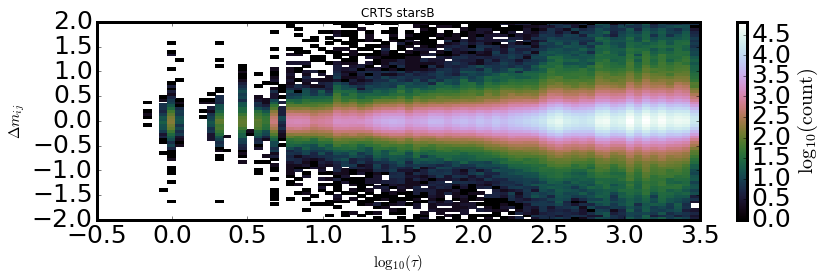

In [36]:
import colorcet as cc
from matplotlib.colors import ListedColormap
#cmap = ListedColormap(cc.colorwheel)
cmap = 'cubehelix'
%matplotlib inline
obj = 'starsB' # qso' #  # QSO 
m_ij = out_dic[obj]['xi']
tau =  out_dic[obj]['tau']
e_ij = out_dic[obj]['ei']


rms_std = lambda x : np.std(x)
nbins = 200
stdev_binned = binned_statistic(tau, m_ij, statistic = rms_std, 
                                      bins=nbins)
binned_tau = binned_statistic(tau, tau, statistic='mean', bins=nbins)
mean_tau = binned_tau[0]
    
non_empty_bins = np.bitwise_not(np.isnan(mean_tau))
bin_stdev = stdev_binned[0][non_empty_bins]

# some m_ij seems completely unphysical... seems that there may be some 'outlier' points in lightcurves 
# that are completely off the scale, and maybe should be discarded at earlier  stage ... 

# makes sense that if there is one outlier point, then all magnitude differences calculated from 
# that point will be offset as much as that point 

m=abs(m_ij)<2

xdata = np.log10(tau[m])
ydata =  m_ij[m]
H, xedges, yedges = np.histogram2d(xdata,ydata, bins=70)
H = np.rot90(H)
H = np.flipud(H)
# Mask zeros
Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zeropltssssss
# Plot 2D histogram using pcolor

fig,ax = plt.subplots(1,1,figsize=(12,4))
image  = ax.pcolormesh(xedges,yedges,np.log10(Hmasked), cmap=cmap)
colorbar = plt.colorbar(image)
colorbar.set_label(r'$\log_{10}{\mathrm{(count)}}$', fontsize=20)


ax.set_xlabel(r'$\log_{10}(\tau)$', fontsize=15)
ax.set_ylabel(r'$\Delta m_{ij}$',fontsize=15)
ax.set_title('CRTS '+obj)
plt.tight_layout()
plt.savefig(outDir+'Fig_2_raw_data_'+obj+'_'+str(Min)+'-'+str(Max)+'.png')

In [38]:
outDir

'/Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-04-18/'

## Calculate SF, mu in approximate and  full  ways

In [46]:
# for all imports of my functions, 
# make python aware of my packages...
import sys
sys.path.insert(0, '../../SDSS_S82_FP_research/packages/')
import variabilityFunctions as varF


In [259]:
#binned_tau

In [47]:
# Run the calculation over all bins : 
# - keep the option to plot a bin if one wants to compare the three methods : need to provide object N
#   
# - as it is, calculate three values for sigma, etc., and plot it  

# set the bin number 
nbins = 200 

# Set a directory to save the results...
outDir = os.path.join(os.getcwd()[:-4]+'data_products/'+'Fig_2_data/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
                      
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_2_data', 
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
                      
print('Today we will save our Fig_2 files in %s'%outDir)

# Loop over objects in the dictionary  
for obj in out_dic.keys():
    print('\n For obj = %s'% obj)
    # obj = 'qso'  # or starsB,  starsR 
    m_ij = out_dic[obj]['xi']
    tau =  out_dic[obj]['tau']
    e_ij = out_dic[obj]['ei']

    # Pull out some tau to plot means : common to all panels 
    binned_tau = binned_statistic(tau, tau, statistic='mean', bins=nbins)
    mean_tau = binned_tau.statistic
    # Take N from each bin... 'count' function works like a regular histogram
    binned_count = binned_statistic(tau, tau, statistic='count', bins=nbins)
    bin_count = binned_count.statistic
    #bin_names = np.arange(1,len(binned_count[2]))

     # Calculate median preprocessed photometric error per bin 
    binned_err_median = binned_statistic(tau, e_ij, statistic='median', bins=nbins) 
    err_median = binned_err_median.statistic

    # checking for empty bins : either mean or some custom function, but not
    # count! If statistic='count', then check for 0's , and not for nan's/ 
    non_empty_bins = np.bitwise_not(np.isnan(mean_tau))

    # reassign number of points in a bin and  tau position 

    bin_count = bin_count[non_empty_bins]
    mean_tau = mean_tau[non_empty_bins]
    err_median = err_median[non_empty_bins]

    # Which point belongs to which bin
    bin_number  = binned_tau.binnumber
    
    ####
    ####  Panel 1 : Standard Deviation 
    ####

    rms_std = lambda x : np.std(x)
    stdev_binned = binned_statistic(tau, m_ij, statistic = rms_std, 
                                              bins=nbins)
    bin_stdev = stdev_binned.statistic[non_empty_bins]  
    #bin_number = stdev_binned[2]  
     # since each point belongs to some bin : len(bin_number) =len(delflx)


    # error on standard deviation in the bin     
    # calculate when plotting, since it's just a function of bin count... 
    
    #err_stdev = bin_stdev / np.sqrt(2.0*(bin_count - 1.0))

    #####
    ##### Panel 2  : Gaussian rms  
    #####
    rms_robust = lambda x : 0.7414 *(np.percentile(x,75) - np.percentile(x,25))
    bin_sigma_G = binned_statistic(tau, m_ij, statistic = rms_robust, 
                                      bins=nbins)[0][non_empty_bins]

    #####
    ##### Panel 3 (SF)   and Panel 4   (mu)
    #####

    # Loop over all bins  calculating approximate mu and sigma 

    mu_bins = {}
    sig_bins = {}

    sig_bins['approx'] = np.zeros(nbins)
    mu_bins['approx'] = np.zeros(nbins)
    sig_bins['full'] = np.zeros(nbins)
    mu_bins['full'] = np.zeros(nbins)
    
    for N in np.unique(bin_number):
        print('\r --- Calculating mu, sigma for bin %d' % N),
        xi = m_ij[bin_number == N]
        ei = e_ij[bin_number == N]
        print('N_points = %d'%len(xi))
        mu_approx, sig_approx = varF.approximate_mu_sigma(xi, ei)
        mu_full, sig_full =  varF.get_mu_sigma(xi,ei)
        
        sig_bins['approx'][N-1] = sig_approx
        sig_bins['full'][N-1] = sig_full
        
        mu_bins['approx'][N-1] = mu_approx
        mu_bins['full'][N-1] = mu_full 


    # Save the results of calculation  : Panel 1,2,3,4 

    fname = outDir+str(Min)+'-'+str(Max)+'_'+obj+'.txt'
    
    data = np.column_stack((mean_tau, bin_stdev, bin_sigma_G, sig_bins['full'], 
                            sig_bins['approx'], mu_bins['full'], mu_bins['approx'], 
                            bin_count))

    header = 'meanTau   stdev    sigmaG   sigmaFull  sigmaApprox   \
    muFull  muApprox   binCount'
    np.savetxt(fname, data, fmt = '%s', delimiter = ' ' , header=header )
    print('Results saved as %s' % fname)

print('Done with calculating panel data ')

Today we will save our Fig_2 files in /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-08-08/

 For obj = qso
 --- Calculating mu, sigma for bin 1
N_points = 36354
 --- Calculating mu, sigma for bin 2
N_points = 46439
 --- Calculating mu, sigma for bin 3
N_points = 34110
 --- Calculating mu, sigma for bin 4
N_points = 33773
 --- Calculating mu, sigma for bin 5
N_points = 22990
 --- Calculating mu, sigma for bin 6
N_points = 24468
 --- Calculating mu, sigma for bin 7
N_points = 15028
 --- Calculating mu, sigma for bin 8
N_points = 16514
 --- Calculating mu, sigma for bin 9
N_points = 9150
 --- Calculating mu, sigma for bin 10
N_points = 10843
 --- Calculating mu, sigma for bin 11
N_points = 7129
 --- Calculating mu, sigma for bin 12
N_points = 8361
 --- Calculating mu, sigma for bin 13
N_points = 7680
 --- Calculating mu, sigma for bin 14
N_points = 9283
 --- Calculating mu, sigma for bin 15
N_points = 8724
 --- Calculating mu, sigma for bin 16
N_points = 14182
 --- 

Plot below the raw $\Delta m_{ij}$ for quasars, applying my mask. 

## Read in the calculation results 

If the calculation for each bin has already been done, and only some fine tuning is needed for the figure, you can set the Min, Max mags for the cut below, and we will read in the results from the files and plot it all. 

In [65]:
import numpy as np 

from collections import OrderedDict
plot_data = OrderedDict()


Min = 18.5
Max = 19

#outDir = '../data_products/Fig_2_data/2017-04-18/'
for obj in ['qso', 'starsB', 'starsR']:
    plot_data[obj] = {}

    fname = outDir+str(Min)+'-'+str(Max)+'_'+obj+'.txt'
    print('Reading from %s'%fname)

    colnames = open(fname,'r').read().splitlines()[0][1:].split()
    d = np.genfromtxt(fname, dtype=float)

    for label, column in zip(colnames, d.T):
        plot_data[obj][label] = column


Reading from /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-08-08/18.5-19_qso.txt
Reading from /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-08-08/18.5-19_starsB.txt
Reading from /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-08-08/18.5-19_starsR.txt


## Make Fig.2 : four-panel plot (can run only cells below to make  Fig.2) 

Note: now since we are convinced that the full results are better than the approximate ones, we plot only muFull and sigmaFull. But muApprox and sigmaApprox is still there... 

In [66]:
import matplotlib 
from matplotlib import rcParamsDefault
from matplotlib import rcParams
#matplotlib.rcParams['font.size'] = 17
rcParams.update(rcParamsDefault)
#matplotlib.rc('xtick', labelsize=15) 
#matplotlib.rc('ytick', labelsize=15) 
rcParams['ytick.labelsize'] = 25
rcParams['xtick.labelsize'] = 25
rcParams['axes.labelsize'] = 35
rcParams['axes.linewidth'] = 3
rcParams['font.size'] = 25

In [67]:
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_2_data', 
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
                      
print('Today we will save our Fig_2 files in %s'%outDir)

Today we will save our Fig_2 files in /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-08-08/


Figure is saved as /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-08-08/Fig_2_18.5-19_sigmaFull.png


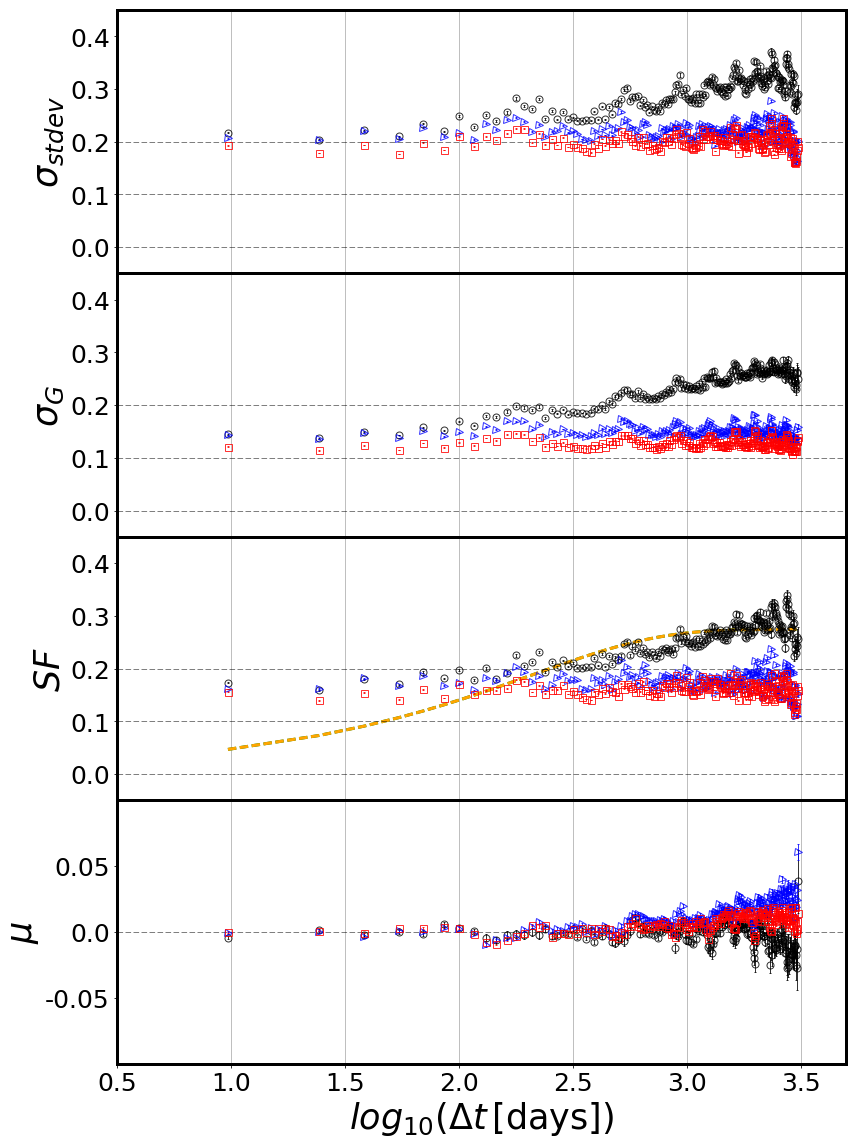

In [258]:
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit
%matplotlib inline
# set all plot parameters
lh_w   = 1.0  # horizontal line thickness 
lh_st  = '--' # horizontal line style 
lh_al  = 0.5  # horizontal line alpha parameter 

# dot size 
p_size = 7 # 7
p_al   = 0.5 

# y limits for sigma, sigma_G, SF panels 
y_top  = 0.45
y_bott = -0.05

# y limits for mu approx 
y_mu_top = 0.1
y_mu_bott = -0.1

# x limits for ALL PANELS 
x_left = 0.5
x_right = 3.7

# colors for quasars, blue and red stars 
colors= {'qso':'black',  'starsB':'blue', 'starsR':'red'}
markers = {'qso':'o',  'starsB': '>', 'starsR': 's'}

# which sigma shall we use as Structure Function ? 
sigma_calc = 'sigmaFull' #'sigmaApprox'

fig,ax = plt.subplots(4,1, figsize=(12,16), sharex=True)

def plot_errorbar(ax, x,y,yerr, obj, linestyle='None', markersize=p_size,
                 markerfacecolor='None',elinewidth=1, 
                  markeredgewidth=1, capsize=1, alpha=0.8, colors=colors, 
                  markers=markers ):
    ''' A quick convenience function to use the 
    same default markers, etc. for all plots
    '''
    ax.errorbar(x,y,yerr,linestyle=linestyle, c = colors[obj],
                marker=markers[obj],  markersize=p_size, markeredgecolor=colors[obj],
                markerfacecolor='None', markeredgewidth=1,  elinewidth=1, capsize=1, 
                alpha=0.8)
    
x = np.log10(plot_data[obj]['meanTau'])

# Panel 1 
for obj in plot_data.keys() : 
    errStdev = plot_data[obj]['stdev'] / np.sqrt(2.0*(plot_data[obj]['binCount'] - 1.0))
    y  = plot_data[obj]['stdev'] ; yerr = errStdev
    plot_errorbar(ax[0], x,y,yerr, obj)

ax[0].set_ylabel(r'$\sigma_{stdev}$') # ,fontsize=20    
ax[0].tick_params( axis='x', which='both',  bottom='off', 
                top='off', labelbottom='off') 
ax[0].set_ylim(bottom=y_bott, top=y_top)
ax[0].set_xlim(left=x_left, right=x_right)
ax[0].set_yticks([0,0.1,0.2,0.3,0.4])
ax[0].set_yticklabels(['0.0','0.1', '0.2', '0.3', '0.4'])
ax[0].axhline(y=0.0, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[0].axhline(y=0.1, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[0].axhline(y=0.2, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[0].grid(axis='x')

# Panel 2
for obj in plot_data.keys() : 
    errSigmaG = plot_data[obj]['sigmaG']* 1.06 / np.sqrt(plot_data[obj]['binCount'])
    y = plot_data[obj]['sigmaG'] ; yerr = errSigmaG
    plot_errorbar(ax[1], x,y,yerr, obj)

ax[1].set_ylabel(r'$\sigma_{G}$')   # ,fontsize=20 
ax[1].tick_params( axis='x', which='both',  bottom='off', 
                top='off', labelbottom='off') 
ax[1].set_ylim(bottom=y_bott, top=y_top)
ax[1].set_xlim(left=x_left, right=x_right)
ax[1].set_yticks([0,0.1,0.2,0.3,0.4])
ax[1].set_yticklabels(['0.0','0.1', '0.2', '0.3', '0.4'])
ax[1].axhline(y=0.0, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[1].axhline(y=0.1, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[1].axhline(y=0.2, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[1].grid(axis='x')

# Panel 3 
def model_sf(t, sf_inf=0.25, tau = 1.0):
    br = 1.0-np.exp(-t/tau)
    sf = sf_inf * np.power(br,0.5)
    return sf

# Calculate the model DRW fit for QSO
obj = 'qso'
xdata = plot_data[obj]['meanTau']
sf = plot_data[obj][sigma_calc]
popt, pcov = curve_fit(model_sf, xdata, sf)
y = model_sf(xdata, sf_inf=popt[0], tau = popt[1]) # tau 1 year in days 

# Fold-in the error to the model SF , plot 
# both folded and not-folded version 

err_sig = plot_data[obj][sigma_calc]* 1.06 / np.sqrt(plot_data[obj]['binCount'])
y_fold = np.sqrt((y ** 2.0)+ (err_sig ** 2.0) )
ax[2].plot(np.log10(xdata), y_fold , lw=3, c = 'green', ls='--')
ax[2].plot(np.log10(xdata), y , lw=3, c = 'orange', ls='--')

for obj in plot_data.keys() : 
    
    #ax[2].scatter(np.log10(plot_data[obj]['meanTau']), plot_data[obj][sigma_calc], 
    #              s=p_size,  alpha=p_al, c = colors[obj])
    err_sig = plot_data[obj][sigma_calc]* 1.06 / np.sqrt(plot_data[obj]['binCount'])
    y = plot_data[obj][sigma_calc]; yerr = err_sig
    plot_errorbar(ax[2], x,y,yerr, obj)
    
ax[2].set_ylim(bottom=y_bott, top=y_top)
ax[2].set_xlim(left=x_left, right=x_right)
ax[2].set_ylabel(r'$SF $') # ,fontsize=20  
ax[2].tick_params( axis='x', which='both',  bottom='off', 
                top='off', labelbottom='off')
ax[2].grid(axis='x')
ax[2].set_yticks([0,0.1,0.2,0.3,0.4])
ax[2].set_yticklabels(['0.0','0.1', '0.2', '0.3', '0.4'])
ax[2].axhline(y=0.0, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)    
ax[2].axhline(y=0.1, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[2].axhline(y=0.2, color='black', lw=lh_w, ls=lh_st,alpha=lh_al) 

# Panel 4 
for obj in plot_data.keys() : 
    err_mu =  plot_data[obj]['stdev'] / np.sqrt(plot_data[obj]['binCount'])
    y  = plot_data[obj]['muFull'] ; yerr = err_mu
    plot_errorbar(ax[3], x,y,yerr, obj)
    
ax[3].axhline(y=0.0, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[3].set_ylim(top=y_mu_top, bottom=y_mu_bott)
ax[3].set_xlim(left=x_left, right=x_right)
ax[3].set_yticks([-0.05,0,0.05])
ax[3].set_yticklabels(['-0.05','0.0', '0.05'])  
ax[3].set_ylabel(r'$\mu$') 
ax[3].grid(axis='x')
ax[3].set_xlabel(r'$log_{10} (\Delta t \, \mathrm{[days]} )$') 

figname = outDir+'Fig_2_'+str(Min)+'-'+str(Max)+'_'+sigma_calc + '.png'
plt.tight_layout()
fig.subplots_adjust(hspace=0)

plt.savefig(figname)
print('Figure is saved as %s'% figname )

# 

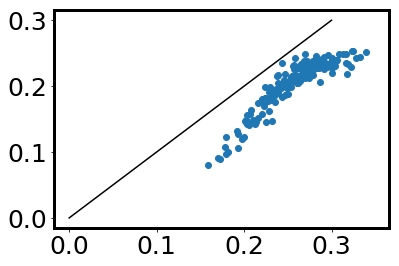

In [51]:
#Show that indeed full vs approximate are slightly different, but not too much..
plt.scatter(plot_data['qso']['sigmaFull'], plot_data['qso']['sigmaApprox'])
plt.plot(np.linspace(0,0.3),np.linspace(0,0.3), color='black')

## Test the calculation results in one $\delta t$ bin

In [165]:
# Choose bin 180...
bin_number = 140
array_pos = bin_number - 1 
obj = 'qso'

# results for stats for each bin are stored as a dic ...
for key in plot_data[obj].keys() : 
    value  = plot_data[obj][key][array_pos]
    print('%20s  %f'% (key, value))


             meanTau  2151.730361
               stdev  0.305648
              sigmaG  0.252224
           sigmaFull  0.279070
         sigmaApprox  0.225385
              muFull  0.004599
            muApprox  0.004700
            binCount  13599.000000


Stdev 0.299847 
bin count 13027
mean 0.007509
median 0.010900
Stdev 0.315496 
bin count 5657
mean 0.002855
median 0.001800
Stdev 0.312848 
bin count 15158
mean -0.004753
median 0.000750
Stdev 0.329959 
bin count 3051
mean -0.026654
median -0.021600
Stdev 0.305648 
bin count 13599
mean 0.004180
median 0.004700
Stdev 0.326319 
bin count 3969
mean -0.002817
median -0.007000
Stdev 0.330171 
bin count 5332
mean -0.014482
median -0.005400
Stdev 0.317587 
bin count 4082
mean 0.004901
median 0.000250
Stdev 0.359009 
bin count 1227
mean -0.025699
median -0.018800
Stdev 0.312159 
bin count 1826
mean -0.021761
median -0.024500


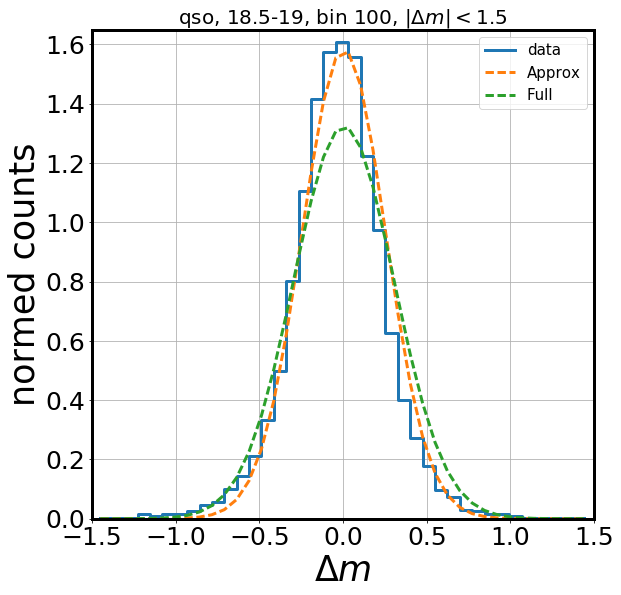

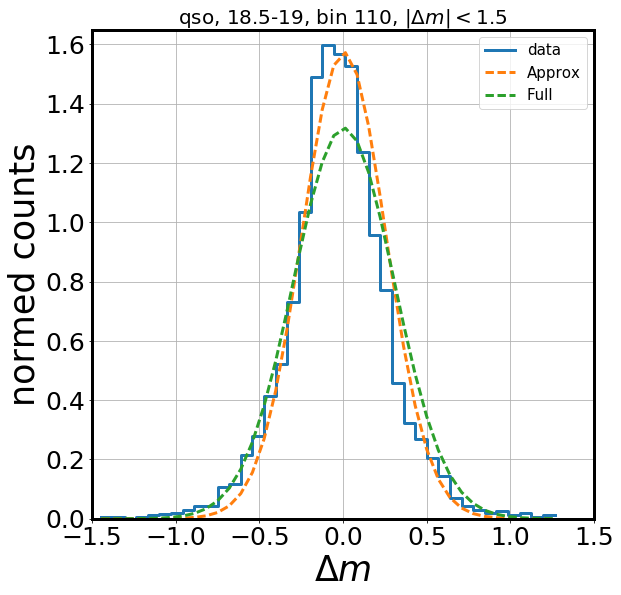

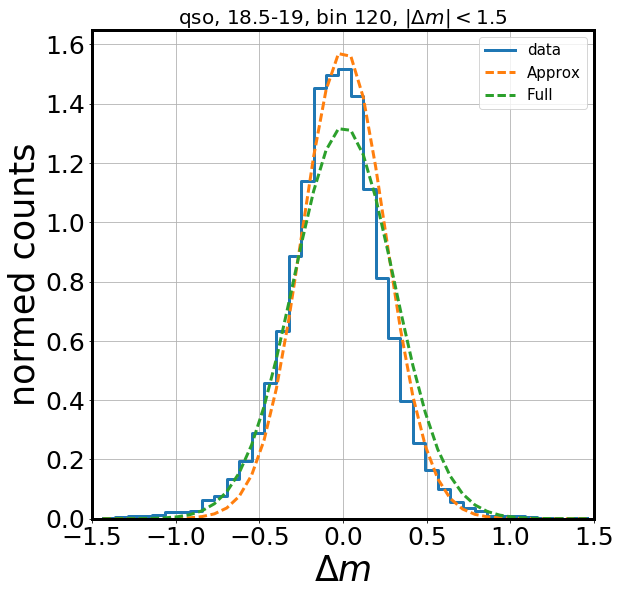

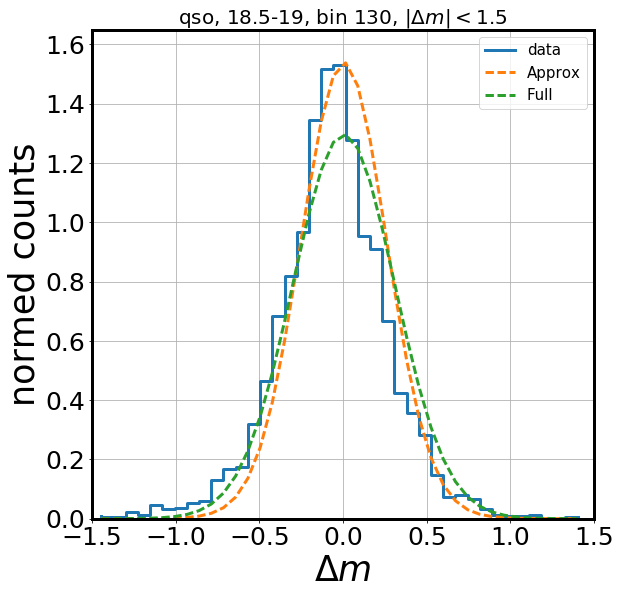

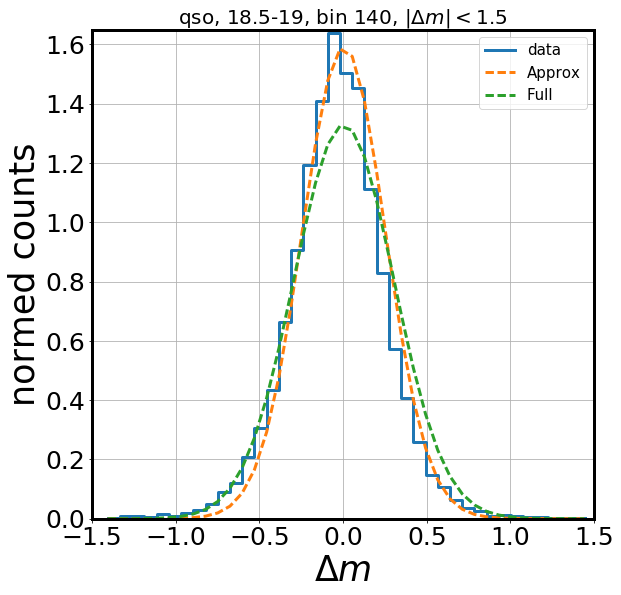

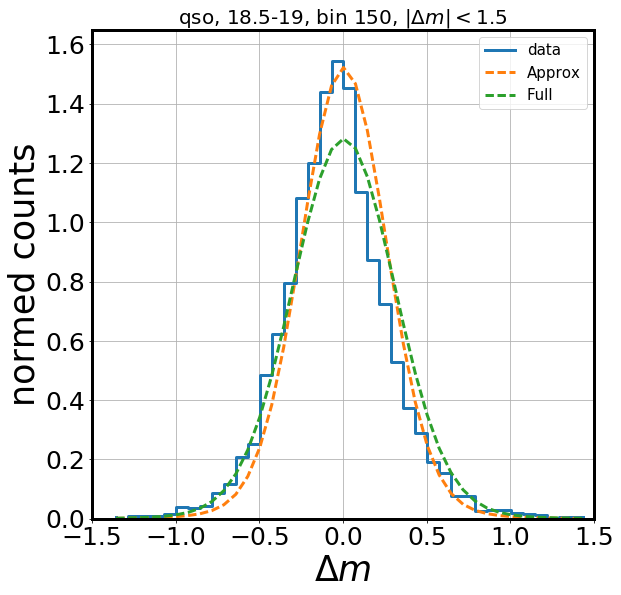

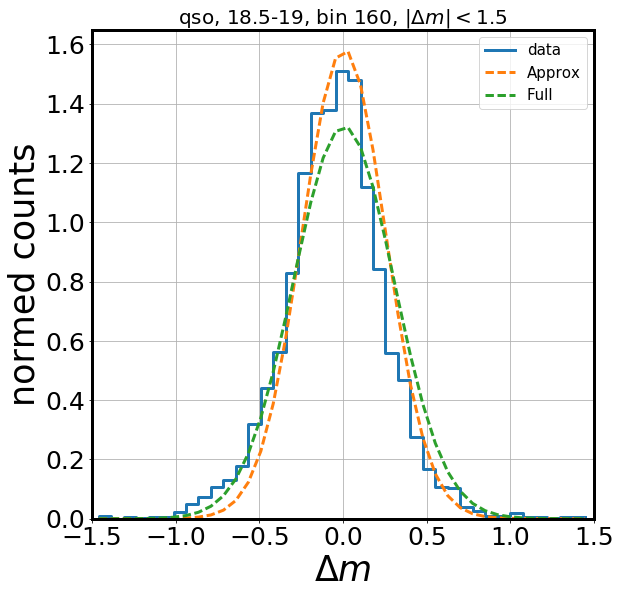

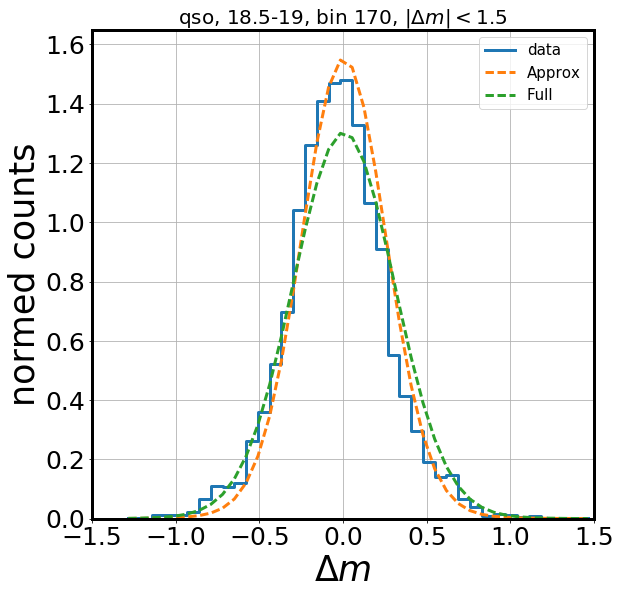

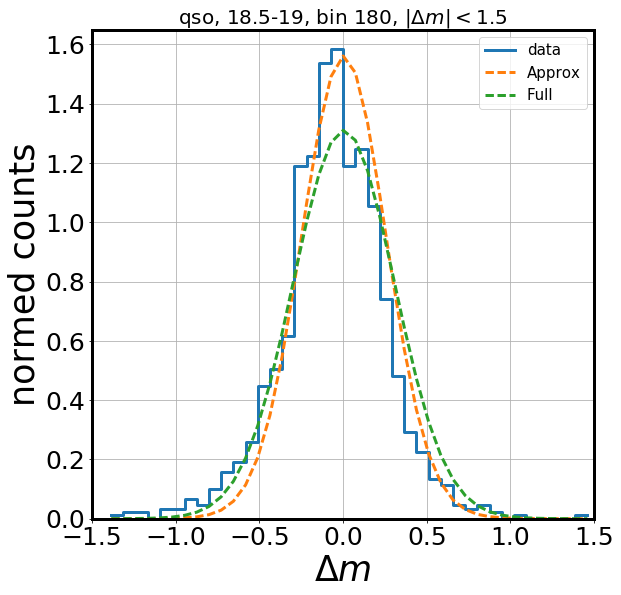

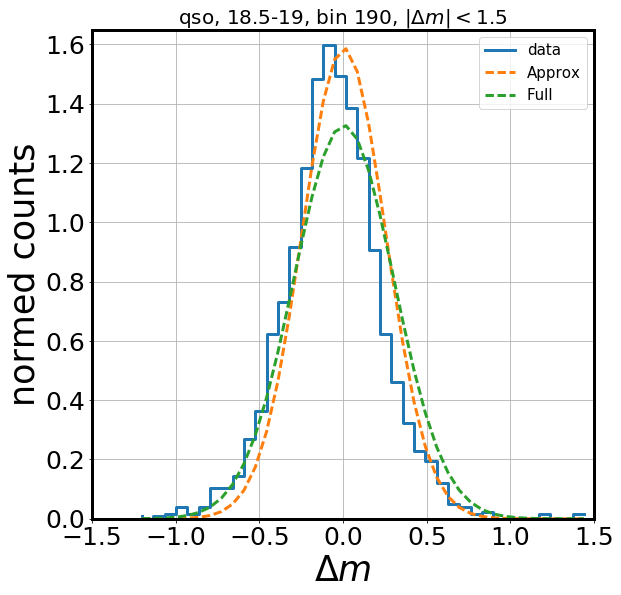

In [257]:
# Select all raw points that enter that bin..
# It's really like making a cross-section 
# through the raw data  plot 

obj = 'qso' #
m_ij = out_dic[obj]['xi']
e_ij = out_dic[obj]['ei']
tau =  out_dic[obj]['tau']

# doesn't matter what statistic , count would suffice : 
# all I need is to bin along tau 
nbins = 200
binned_tau = binned_statistic(tau, tau, statistic = 'count', bins=nbins)

max_mi = 1.5

# choose the bin to analyze ...
for Nb in np.arange(100,200,10) : 

    # Sanity check : 
    # whatever stdev  or  bin count I find here,
    # ought be exactly the same as in the previously calculated 
    # stats...
    m1 = binned_tau.binnumber == Nb
    print('Stdev %f '% np.std(m_ij[m1]))
    print('bin count %d'%np.sum(m1))
    print('mean %f'%np.mean(m_ij[m1]))
    # muApprox is a median ... 
    print('median %f'%np.median(m_ij[m1])) 

    fig,ax = plt.subplots(1,1,figsize=(9,9))
    # do clipping for the sake of clean histogram..
    m2 = np.abs(m_ij)  <  max_mi
    m = m1 * m2 
    mi = m_ij[m]
    ei = e_ij[m]


    def model(xi, SF=None, mu=None, ei=ei) : 
        sig_i_tot = np.sqrt(ei**2.0 + SF**2.0)
        summed = (1 / (np.sqrt(2 * np.pi ) * sig_i_tot)) * \
             np.exp(-(xi-mu)**2.0 / (2 * sig_i_tot**2.0) )
        return np.sum(summed)

    # Plot the data histogram 
    hist, bin_edges = np.histogram(mi, bins=40, normed=True)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    ax.plot(bin_centres, hist, ls='steps', label='data', lw=3)

    # choose model plot ls, lw 
    ls = '--'
    lw= 3

    # overplot the approx model evaluated on the bin_centres

    choice = 'Approx'
    SF= plot_data[obj]['sigma'+choice][array_pos]
    mu = plot_data[obj]['mu'+choice][array_pos]

    y  = np.array([model(mi, SF=SF, mu = mu) for mi in bin_centres])
    step = (bin_centres[1] - bin_centres[0]) 
    # normalize : that way,  
    y = y / np.sum(step*y)
    # np.sum(y * step) = 1.0 , just as we'd have 
    # for a normed histogram 
    ax.plot(bin_centres, y, label=choice, ls=ls, lw=lw )

    # overplot the full model evaluated on the bin_centres
    choice = 'Full'
    SF = plot_data[obj]['sigma'+choice][array_pos]
    mu = plot_data[obj]['mu'+choice][array_pos]

    y  = np.array([model(mi, SF=SF, mu = mu) for mi in bin_centres])
    step = (bin_centres[1] - bin_centres[0]) 
    # normalize : that way,  
    y = y / np.sum(step*y)
    # np.sum(y * step) = 1.0 , just as we'd have 
    # for a normed histogram 
    ax.plot(bin_centres, y, label=choice, ls=ls, lw=lw )
    plt.legend(fontsize=15)

    ax.set_xlabel(r'$\Delta m$')
    ax.set_ylabel('normed counts')
    ax.grid()

    ax.set_title('qso, 18.5-19, bin '+str(Nb)+', '+ r'$|\Delta m| < 1.5$', 
                 fontsize=20)
    ax.set_xlim(-max_mi,max_mi)
    ax.set_ylim(0,1.65)
    plt.savefig(outDir + 'qso_18.5-19_bin_'+str(Nb)+'.png', bbox_inches=  'tight')

In [254]:
outDir

'/Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-08-08/'

In [231]:
np.sum(step*y / np.sum(step*y))

1.0

(array([  1.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          4.00000000e+00,   9.00000000e+00,   1.00000000e+01,
          1.70000000e+01,   1.50000000e+01,   2.80000000e+01,
          5.60000000e+01,   1.21000000e+02,   2.15000000e+02,
          3.77000000e+02,   6.37000000e+02,   1.07100000e+03,
          1.51700000e+03,   1.98500000e+03,   2.07200000e+03,
          1.95600000e+03,   1.38100000e+03,   9.16000000e+02,
          5.44000000e+02,   2.96000000e+02,   1.59000000e+02,
          8.20000000e+01,   4.50000000e+01,   2.00000000e+01,
          1.90000000e+01,   8.00000000e+00,   9.00000000e+00,
          3.00000000e+00,   1.00000000e+00,   5.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          3.00000000e+00]),
 array([-1.9991   , -1.9004975, -1.801895 , -1.7032925, -1.60469  ,
        -1.5060875, -1.407485 , -1.3088825, -1.21028  , -1.1116775,
        -1.013075 , -0.9144725

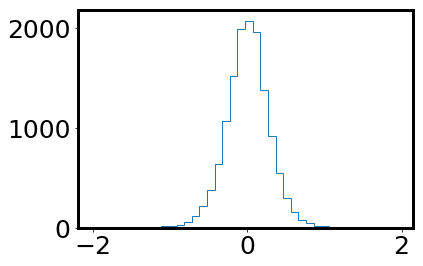

In [162]:
# plot the histogram Zeljko described ... 

# do some clipping ....
m2 = np.abs(m_ij)  < 2 
m = m1 * m2 
plt.hist(m_ij[m], histtype='step', bins=40)


2381082

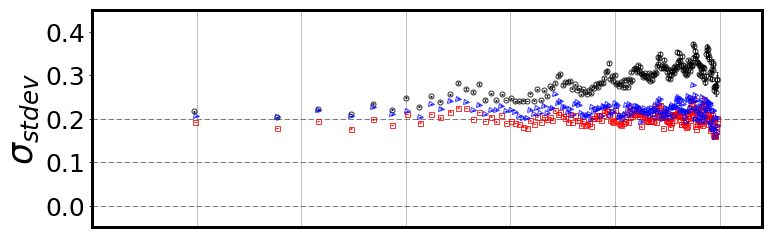

In [120]:
fig,ax = plt.subplots(1,1,figsize=(12,4))
# Panel 1 
p_size=5

def plot_errorbar(ax, x,y,yerr, obj, linestyle='None', markersize=p_size,
                 markerfacecolor='None',elinewidth=1, 
                  markeredgewidth=1,
                capsize=1, alpha=0.8, colors=colors, markers=markers   ):
    ''' A quick convenience function to use the 
    same default markers, etc. for all plots
    '''
    ax.errorbar(x,y,yerr,linestyle=linestyle, c = colors[obj],
                marker=markers[obj],
                markersize=p_size,
                markeredgecolor=colors[obj],
                markerfacecolor='None',
                markeredgewidth=1,
                elinewidth=1,
                capsize=1, 
                alpha=0.8)


for obj in ['qso', 'starsR', 'starsB'] : 
    #ax.scatter(np.log10(plot_data[obj]['meanTau']), plot_data[obj]['stdev'], s=p_size, 
    #                alpha=0, c = colors[obj], marker=markers[obj],
    #          )
    errStdev = plot_data[obj]['stdev'] / np.sqrt(2.0*(plot_data[obj]['binCount'] - 1.0))
    # https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.errorbar.html
    x = np.log10(plot_data[obj]['meanTau'])
    y = plot_data[obj]['stdev'] ; yerr = errStdev
    plot_errorbar(ax, x,y,yerr, obj)
    #ax.errorbar(np.log10(plot_data[obj]['meanTau']), plot_data[obj]['stdev'], 
    #             yerr=errStdev, 
    #               linestyle='None', c = colors[obj]  ,  markeredgecolor=colors[obj],
    #            marker=markers[obj],markersize=p_size,
    #              markerfacecolor='None',elinewidth=1, markeredgewidth=1,
    #           capsize=1, alpha=0.8  )

ax.set_ylabel(r'$\sigma_{stdev}$') # ,fontsize=20    
ax.tick_params( axis='x', which='both',  bottom='off', 
                top='off', labelbottom='off') 
ax.set_ylim(bottom=y_bott, top=y_top)
ax.set_xlim(left=x_left, right=x_right)
ax.set_yticks([0,0.1,0.2,0.3,0.4])
ax.set_yticklabels(['0.0','0.1', '0.2', '0.3', '0.4'])
ax.axhline(y=0.0, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax.axhline(y=0.1, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax.axhline(y=0.2, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax.grid(axis='x')

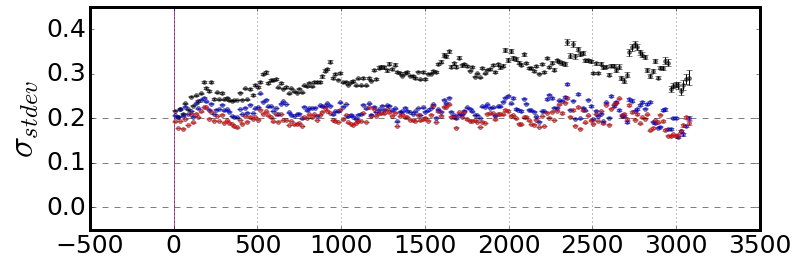

In [45]:
### Take data from the peak and the minimum around 1000 days  (log(t) = 3) .  

# First show the zoom - in , to discern where to zoom ... 

%matplotlib inline
# set all plot parameters
lh_w   = 1.0  # horizontal line thickness 
lh_st  = '--' # horizontal line style 
lh_al  = 0.5  # horizontal line alpha parameter 

# dot size 
p_size = 14 # 7
p_al   = 0.5 

# y limits for sigma, sigma_G, SF panels 
y_top  = 0.45
y_bott = -0.05

# x limits for ALL PANELS 
x_left = 0.7
x_right = 3.6

# colors for quasars, blue and red stars 
colors= {}
colors['qso'] = 'black'
colors['starsB'] = 'blue'
colors['starsR']   = 'red'

fig,ax = plt.subplots(1,1, figsize=(12,4))


# Panel 1 
for obj in plot_data.keys() : 
    ax.scatter(plot_data[obj]['meanTau'], plot_data[obj]['stdev'], s=p_size, 
                    alpha=p_al, c = colors[obj])
    errStdev = plot_data[obj]['stdev'] / np.sqrt(2.0*(plot_data[obj]['binCount'] - 1.0))
    ax.errorbar(plot_data[obj]['meanTau'], plot_data[obj]['stdev'],errStdev, 
                   linestyle='None', c = colors[obj]  )

ax.set_ylabel(r'$\sigma_{stdev}$') # ,fontsize=20    
#ax.tick_params( axis='x', which='both',  bottom='off', 
#                top='off', labelbottom='off') 
ax.set_ylim(bottom=y_bott, top=y_top)
#ax.set_xlim(left=x_left, right=x_right)
ax.set_yticks([0,0.1,0.2,0.3,0.4])
ax.set_yticklabels(['0.0','0.1', '0.2', '0.3', '0.4'])
ax.axhline(y=0.0, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax.axhline(y=0.1, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax.axhline(y=0.2, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax.grid(axis='x')


ax.axvspan(2.93, 3.0,  color='orange',alpha=0.5)
ax.axvspan(2.82,2.9, color='green',alpha=0.5)
ax.axvspan(2.69,2.77, color='magenta', alpha=0.5)
plt.savefig(outDir + 'Fig_2_'+str(Min)+'-'+str(Max)+'_stdev_Min_Max.png')

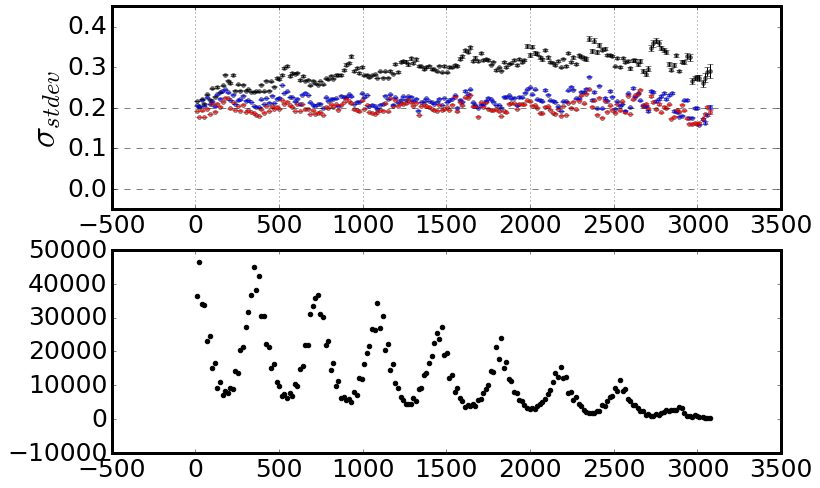

In [46]:
# Plot only sigmaG  and number of counts .... 

### Take data from the peak and the minimum around 1000 days  (log(t) = 3) .  
# First show the zoom - in , to discern where to zoom ... 

%matplotlib inline
# set all plot parameters
lh_w   = 1.0  # horizontal line thickness 
lh_st  = '--' # horizontal line style 
lh_al  = 0.5  # horizontal line alpha parameter 

# dot size 
p_size = 14 # 7
p_al   = 0.5 

# y limits for sigma, sigma_G, SF panels 
y_top  = 0.45
y_bott = -0.05

# x limits for ALL PANELS 
x_left = 0.7
x_right = 3.6

# colors for quasars, blue and red stars 
colors= {}
colors['qso'] = 'black'
colors['starsB'] = 'blue'
colors['starsR']   = 'red'

fig,(ax1, ax2) = plt.subplots(2,1, figsize=(12,8))


# Panel 1 
for obj in plot_data.keys() : 
    ax1.scatter(plot_data[obj]['meanTau'], plot_data[obj]['stdev'], s=p_size, 
                    alpha=p_al, c = colors[obj])
    errStdev = plot_data[obj]['stdev'] / np.sqrt(2.0*(plot_data[obj]['binCount'] - 1.0))
    ax1.errorbar(plot_data[obj]['meanTau'], plot_data[obj]['stdev'],errStdev, 
                   linestyle='None', c = colors[obj]  )

ax1.set_ylabel(r'$\sigma_{stdev}$') # ,fontsize=20    
#ax.tick_params( axis='x', which='both',  bottom='off', 
#                top='off', labelbottom='off') 
ax1.set_ylim(bottom=y_bott, top=y_top)
#ax.set_xlim(left=x_left, right=x_right)
ax1.set_yticks([0,0.1,0.2,0.3,0.4])
ax1.set_yticklabels(['0.0','0.1', '0.2', '0.3', '0.4'])
ax1.axhline(y=0.0, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax1.axhline(y=0.1, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax1.axhline(y=0.2, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax1.grid(axis='x')

obj = 'qso'
ax2.scatter(plot_data[obj]['meanTau'], plot_data[obj]['binCount'], c='black')

#ax.axvspan(2.93, 3.0,  color='orange',alpha=0.5)
#ax.axvspan(2.82,2.9, color='green',alpha=0.5)
#ax.axvspan(2.69,2.77, color='magenta', alpha=0.5)
plt.savefig(outDir + 'Fig_2_'+str(Min)+'-'+str(Max)+'_stdev_counts.png')

### Read only detailed master files  for stars and quasars: save detail_dic

In [9]:
Min = 18.5
Max = 19
mag = 'r'
mod.cut_stars(star_cat = star_cat, mMin = Min, 
                               mMax=Max, mErrMax = 0.3, gi_Min = -1, gi_Max=3, 
                               cut_mag=mag + '_mMed')


Choosing stars with  SDSS   -1.00<g-i<3.00
 These cuts reduced the number of stars  in the sample from 48250 to 3825


array(['1000283', '1000477', '1000513', ..., '998545', '998705', '999873'], 
      dtype='<U7')

In [62]:
imp.reload(mod)

Min_arr = [ 18,   18.5 ]
Max_arr = [ 18.5, 19   ]

detail_dic = {}
detail_dic['qso'] = {}
detail_dic['stars'] = {}

mag = 'r'   # which magnitudes to use for cutting and reporting 
inDirStars   = '../data_products/sf_file_per_LC/stars_detailed/'
inDirQSO = '../data_products/sf_file_per_LC/qso_detailed/'
        

for i in range(len(Min_arr)):
    
    Min = Min_arr[i]
    Max = Max_arr[i]

    print('\nUsing now only lightcurves with SDSS  %f< %s < %f' % (Min, mag, Max))

    detail_dic['qso'][Min] = mod.faster_read_xi_ei(inDirSF = inDirQSO, 
                                                   good_ids= mod.cut_qso(qso_cat=qso_cat, mMin = Min, 
                                                   mMax=Max, mErrMax = 0.3, cut_mag=mag), detailed=True)

    # we combin blue and red stars by choosing g-i from   -1 to 1 and 1 to 3 together 
    detail_dic['stars'][Min] = mod.faster_read_xi_ei(inDirSF =inDirStars,  
                               good_ids = mod.cut_stars(star_cat = star_cat, mMin = Min, 
                               mMax=Max, mErrMax = 0.3, gi_Min = -1, gi_Max=3, 
                               cut_mag=mag + '_mMed'), 
                               detailed=True)


    


Using now only lightcurves with SDSS  18.000000< r < 18.500000

 Returning only QSO with  an SDSS counterpart within 2.000000 arcsec

 These cuts reduced the number of qso  in the sample from 7601 to 333

Reading in tau,xi,ei  for 333 objects

Using structure function master files from ../data_products/sf_file_per_LC/qso_detailed/

Reading in detailed SF : t1, t2, e1, e2, m1, m2
[######### ] 99.10%
Finished reading all master files for the selected objects ...

Choosing stars with  SDSS   -1.00<g-i<3.00
 These cuts reduced the number of stars  in the sample from 48250 to 3487

Reading in tau,xi,ei  for 3487 objects

Using structure function master files from ../data_products/sf_file_per_LC/stars_detailed/

Reading in detailed SF : t1, t2, e1, e2, m1, m2
[######### ] 99.94%
Finished reading all master files for the selected objects ...

Using now only lightcurves with SDSS  18.500000< r < 19.000000

 Returning only QSO with  an SDSS counterpart within 2.000000 arcsec

 These cuts reduc

In [65]:
# Save the QSO, stellar detailed master files into bigger combined files.

for obj in ['qso', 'stars'] : 
    for i in range(len(Min_arr)) : 
        Min = Min_arr[i]
        Max = Max_arr[i]
        np.save(outDir + obj+'_' +str(Min)+'-'+str(Max) , detail_dic[obj][Min])

## Load the detail_dic for qso and stars 

In [3]:
# Load the 
# Need to select the outDir : 

outDir = '../data_products/Fig_2_data/2017-04-19/'

Min_arr = [ 18,   18.5 ]
Max_arr = [ 18.5, 19   ]

# Load the files if needed later ....
detail_dic = {}
for obj in ['qso', 'stars'] : 
    detail_dic[obj] = {}
    
    for i in range(len(Min_arr)) : 
        Min = Min_arr[i]
        Max = Max_arr[i]
        detail_dic[obj][Min] = np.load(outDir + obj+'_' +str(Min)+'-'+str(Max)+'.npy').item()
        
print('Read detailed xi, ei data from %s'%outDir)

Read detailed xi, ei data from ../data_products/Fig_2_data/2017-04-19/


In [8]:
# Set a new outDir for today ... 

outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_2_data', 
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
                      
print('Today we will save our Fig_2 files in %s'%outDir)




Today we will save our Fig_2 files in /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-05-03/


In [211]:
import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (500,-1))


In [14]:
len(detail_dic['stars'][18.5]['tau'])

13199750

### Plot the 'corner' plots 

Read the saved detailed xi, ei, tau, m1, m2, t1, t2, e1, e2  data arrays  .... 

Saved as /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-04-19/QSO_18.5-19.0_t1_vs_t2_tau_1.258-3162._days_count.png
Saved as /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-04-19/QSO_18.5-19.0_t1_vs_t2_tau_1.258-3162._days_sigmaG.png


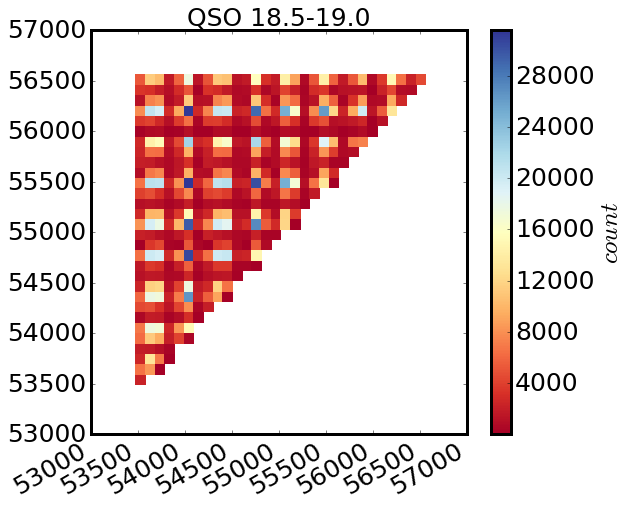

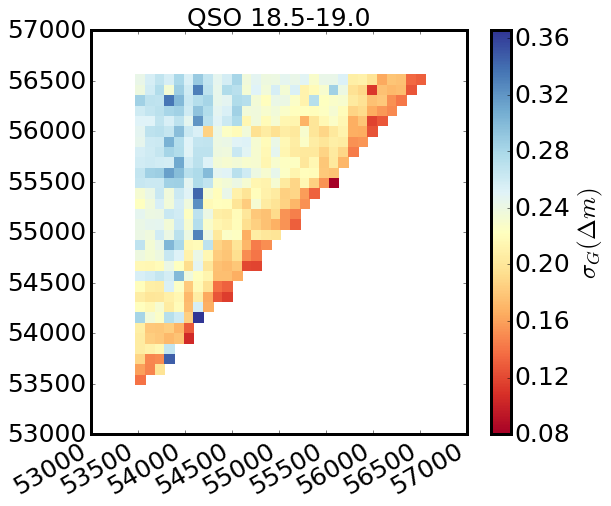

In [71]:
from scipy.stats import binned_statistic_2d

# Plot the t1 vs t2... 

pre = 'QSO' # 'Stars' # 'QSO'
Min =  18.5
Max = Min + 0.5 


obj = 'qso'
x = detail_dic[obj][Min]['t1']
y = detail_dic[obj][Min]['t2']
z = detail_dic[obj][Min]['xi']

def func(num) :
    return 0.7413*(np.percentile(num, 75) - np.percentile(num,25))


# set bin size for both plots .... 
bin_size_days = 100 
nbins = int((max(x) - min(x)) / bin_size_days )

# plot 1 :  t1 vs t2 colored by  count 
stats = binned_statistic_2d(x, y, values = z, statistic='count', bins=nbins)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_sigma[np.isnan(z_sigma)] =0
z_reduce  =  z_sigma # [:-1, :-1] no need to reduce here because x_edges are already given with the right size
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display...
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros...

# Plot 2D histogram using pcolor
fig,ax = plt.subplots(1,1, figsize=(8,7))
cm = plt.cm.get_cmap('RdYlBu')
image = ax.pcolormesh(x_edges,y_edges,z_masked, cmap=cm)  # np.log10(z_masked) gives log counts
fig.autofmt_xdate()
plt.tight_layout()
colorbar = fig.colorbar(image, ax = ax,  orientation='vertical')
colorbar.set_label(r'$count$', fontsize=25)


ax.set_title(pre+' '+str(Min)+'-'+str(Min+0.5), fontsize=25)
title = pre+'_'+str(Min)+'-'+str(Max)+'_t1_vs_t2_tau_'+str(tau_min)[:5]+'-'+str(tau_max)[:5]+'_days_count.png'
plt.savefig(outDir + title, bbox_inches='tight')
print('Saved as %s'%(outDir+title))


# plot 2 :  t1 vs t2 colored by  sigmaG(xi) per bin 

stats = binned_statistic_2d(x, y, values = z, statistic=func, bins=nbins)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_sigma[np.isnan(z_sigma)] =0
z_reduce  =  z_sigma # [:-1, :-1] no need to reduce here because x_edges are already given with the right size
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display...
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros...

# Plot 2D histogram using pcolor
fig,ax = plt.subplots(1,1, figsize=(8,7))
image = ax.pcolormesh(x_edges,y_edges,z_masked, cmap=cm)  # np.log10(z_masked) gives log counts
fig.autofmt_xdate()
plt.tight_layout()
colorbar = fig.colorbar(image, ax = ax,  orientation='vertical')
colorbar.set_label(r'$\sigma_{G}(\Delta m)$', fontsize=25)

ax.set_title(pre+' '+ str(Min)+'-'+str(Min+0.5), fontsize=25)
title = pre+'_'+str(Min)+'-'+str(Max)+'_t1_vs_t2_tau_'+str(tau_min)[:5]+'-'+str(tau_max)[:5]+'_days_sigmaG.png'
plt.savefig(outDir + title, bbox_inches='tight')
print('Saved as %s'%(outDir+title))


### Given x,y,z : scatter plot x vs y and color by z  

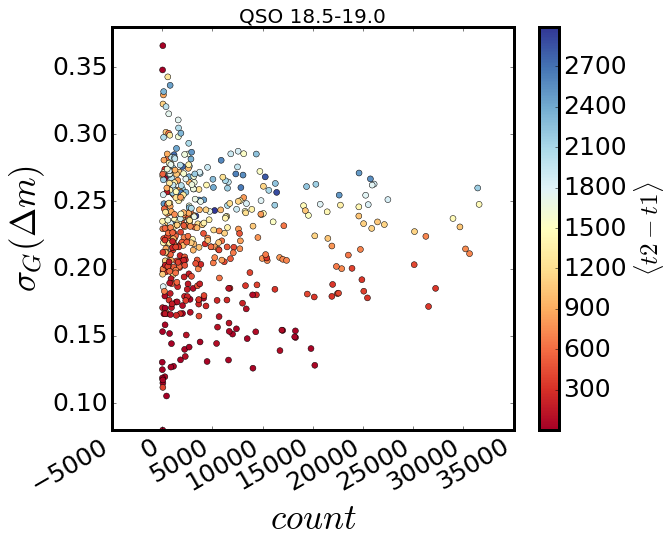

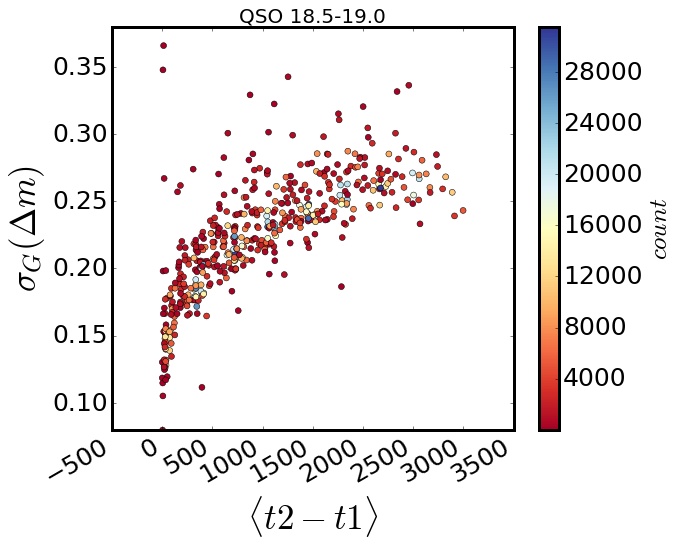

In [72]:
# Grab x,y  pixel values when evaluating  sigmaG(z) per pixel,  and  count(x) per pixel  

# Plot the t1 vs t2... 
Min =  18.5
Max = Min + 0.5 
pre = 'QSO' # 'Stars'  

yMin, yMax = 0.08, 0.38

obj = 'qso'
x = detail_dic[obj][Min]['t1']
y = detail_dic[obj][Min]['t2']
z = detail_dic[obj][Min]['xi']

def sigmaG(num) :
    ''' A quick function to calculate sigmaG'''
    return 0.7413*(np.percentile(num, 75) - np.percentile(num,25))


# Calculate  2D statistics on  t2-t1 bins ... 
bin_size_days = 100 
nbins = int((max(x) - min(x)) / bin_size_days )  

stats = binned_statistic_2d(x, y, values = z, statistic=sigmaG, bins=nbins)
z_sigmaG, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigmaG = z_sigmaG.flatten()

stats = binned_statistic_2d(x, y, values = z, statistic='count', bins=nbins)
z_count, x_edges, y_edges = stats[0], stats[1], stats[2]
z_count = z_count.flatten()

z = y-x 
stats = binned_statistic_2d(x, y, values = z, statistic='mean', bins=nbins)
z_t2t1, x_edges, y_edges = stats[0], stats[1], stats[2]
z_t2t1 = z_t2t1.flatten()

# Given three pieces of information per bin : 
# sigmaG(delta_mag) ,   mean(t2-t1)  , count ,
# can plot x vs y, and color by z  

fig,ax = plt.subplots(1,1, figsize=(9,8))
cm = plt.cm.get_cmap('RdYlBu')
sc = ax.scatter(z_count, z_sigmaG, lw=0.5, c =z_t2t1 , s=35, cmap = cm )
cbar = plt.colorbar(sc)
cbar.set_label(r'$\langle t2-t1 \rangle$', fontsize=25)



fig.autofmt_xdate()
ax.set_title( pre+ ' '+str(Min)+'-'+str(Min+0.5), fontsize=20)
ax.set_xlabel(r'$count$')
ax.set_ylabel(r'$\sigma_{G}(\Delta m)$')
ax.set_ylim(yMin, yMax)
#ax.set_xlim(-100, )
title = pre+'_'+str(Min)+'-'+str(Max)+'sigmaG-count.png'
plt.savefig(outDir +title, bbox_inches = 'tight')
plt.show()


fig,ax = plt.subplots(1,1, figsize=(9,8))
sc = ax.scatter(z_t2t1, z_sigmaG, lw=0.5, c = z_count, s=35, cmap=cm)
cbar = plt.colorbar(sc)
cbar.set_label(r'$ count $', fontsize=25)


fig.autofmt_xdate()
ax.set_title(pre+' '+str(Min)+'-'+str(Min+0.5), fontsize=20)
ax.set_xlabel(r'$\langle t2-t1  \rangle $')
ax.set_ylabel(r'$\sigma_{G}(\Delta m)$')
ax.set_ylim(yMin, yMax)
title = pre+'_'+str(Min)+'-'+str(Max)+'sigmaG-t1-t2.png'
plt.savefig(outDir +title, bbox_inches = 'tight')
plt.show()


## Raw data check ... 

In [769]:
# Make a new dir ... 
# Set a directory to save the results...
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_2_data', 
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
                      
print('Today we will save our Fig_2 files in %s'%outDir)



Today we will save our Fig_2 files in /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-05-01/


In [259]:
detail_dic.keys()

dict_keys(['qso', 'stars'])

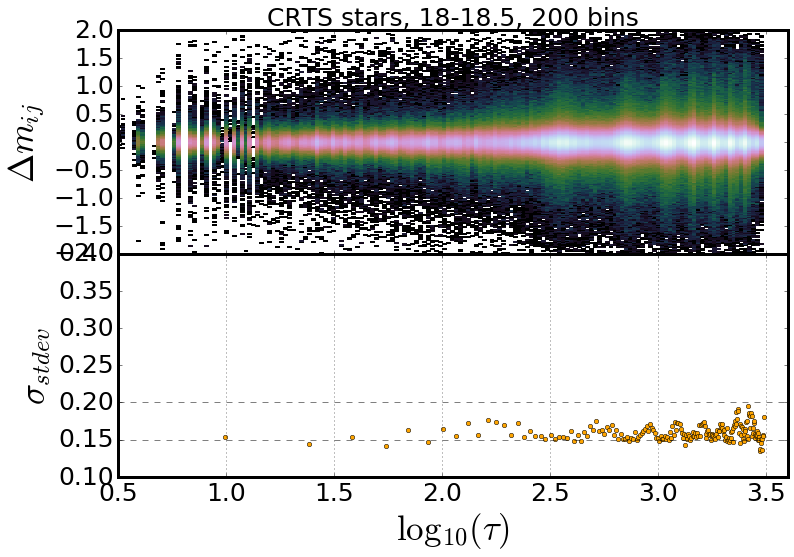

In [321]:
# Make raw plots first .... 

import colorcet as cc
from matplotlib.colors import ListedColormap
#cmap = ListedColormap(cc.colorwheel)
cmap = 'cubehelix'
%matplotlib inline
obj = 'stars' # qso' # stars' # qso' #  # QSO 
Min = 18
tau = detail_dic[obj][Min]['tau']
e_ij = detail_dic[obj][Min]['ei']
m_ij = detail_dic[obj][Min]['xi']


rms_std = lambda x : np.std(x)
nbins = 200
stdev_binned = binned_statistic(tau, m_ij, statistic = rms_std, 
                                      bins=nbins)
binned_tau = binned_statistic(tau, tau, statistic='mean', bins=nbins)
mean_tau = binned_tau[0]
    
non_empty_bins = np.bitwise_not(np.isnan(mean_tau))
bin_stdev = stdev_binned[0][non_empty_bins]

# some m_ij seems completely unphysical... seems that there may be some 'outlier' points in lightcurves 
# that are completely off the scale, and maybe should be discarded at earlier  stage ... 

# makes sense that if there is one outlier point, then all magnitude differences calculated from 
# that point will be offset as much as that point 

m=abs(m_ij)<2

xdata = np.log10(tau[m])
ydata =  m_ij[m]
H, xedges, yedges = np.histogram2d(xdata,ydata, bins=nbins)
H = np.rot90(H)
H = np.flipud(H)
# Mask zeros
Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zeropltssssss
# Plot 2D histogram using pcolor

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,8), sharex=True)
image  = ax1.pcolormesh(xedges,yedges,np.log10(Hmasked), cmap=cmap)



#colorbar = plt.colorbar(image)
#colorbar.set_label(r'$\log_{10}{\mathrm{(count)}}$', fontsize=20)


# set all plot parameters
lh_w   = 1.0  # horizontal line thickness 
lh_st  = '--' # horizontal line style 
lh_al  = 0.5  # horizontal line alpha parameter 
xmin, xmax = 0.5, 3.6
ymin, ymax = 0.1, 0.4

ax1.set_ylabel(r'$\Delta m_{ij}$')
ax1.set_title('CRTS '+obj+', '+str(Min)+'-'+str(Min+0.5)+', '+str(nbins)+' bins', fontsize=25)
ax1.set_xlim(xmin,xmax)

ax2.scatter(np.log10(mean_tau), bin_stdev,lw=0.5,c='orange')
ax2.set_xlabel(r'$\log_{10}(\tau)$')
ax2.set_ylabel(r'$\sigma_{stdev}$')
ax2.set_xlim(xmin,xmax)
ax2.axhline(y=0.0, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax2.axhline(y=0.15, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax2.axhline(y=0.2, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax2.grid(axis='x')
ax2.set_ylim(ymin, ymax)

fig.subplots_adjust(hspace=0)

#plt.tight_layout()
plt.savefig(outDir+'Fig_2_raw_data_'+obj+'_'+str(Min)+'-'+str(Max)+'_'+str(nbins)+'-bins.png')


There are 12470880 points in the plot, and 4308 points outside the plot bounds


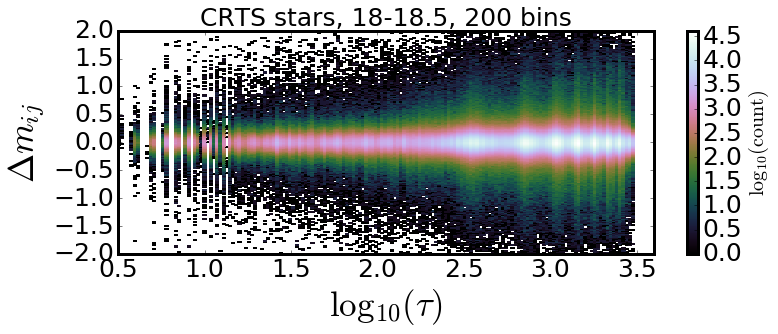

In [773]:
# Just plot raw data ....
# Make raw plots first .... 

import colorcet as cc
from matplotlib.colors import ListedColormap
#cmap = ListedColormap(cc.colorwheel)
cmap = 'cubehelix'
%matplotlib inline
obj = 'stars' # qso' # stars' # qso' #  # QSO 
Min = 18
tau = detail_dic[obj][Min]['tau']
e_ij = detail_dic[obj][Min]['ei']
m_ij = detail_dic[obj][Min]['xi']


# some m_ij seems completely unphysical... seems that there may be some 'outlier' points in lightcurves 
# that are completely off the scale, and maybe should be discarded at earlier  stage ... 

# makes sense that if there is one outlier point, then all magnitude differences calculated from 
# that point will be offset as much as that point 

m=abs(m_ij)<2
print('There are %d points in the plot, and %d points outside the plot bounds'%(np.sum(m), np.sum(~m)))

xdata = np.log10(tau[m])
ydata =  m_ij[m]
nbins = 200 
H, xedges, yedges = np.histogram2d(xdata,ydata, bins=nbins)
H = np.rot90(H)
H = np.flipud(H)
# Mask zeros
Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zeropltssssss
# Plot 2D histogram using pcolor

fig, ax = plt.subplots(1,1,figsize=(12,4))
image  = ax.pcolormesh(xedges,yedges,np.log10(Hmasked), cmap=cmap)


colorbar = plt.colorbar(image)
colorbar.set_label(r'$\log_{10}{\mathrm{(count)}}$', fontsize=20)


# set all plot parameters
lh_w   = 1.0  # horizontal line thickness 
lh_st  = '--' # horizontal line style 
lh_al  = 0.5  # horizontal line alpha parameter 
xmin, xmax = 0.5, 3.6
ymin, ymax = 0.1, 0.4

ax.set_ylabel(r'$\Delta m_{ij}$')
ax.set_xlabel(r'$\log_{10}(\tau)$')
ax.set_title('CRTS '+obj+', '+str(Min)+'-'+str(Min+0.5)+', '+str(nbins)+' bins', fontsize=25)
ax.set_xlim(xmin,xmax)
plt.savefig(outDir+'Fig_2_raw_data_'+obj+'_'+str(Min)+'-'+str(Max)+'_'+str(nbins)+'-bins.png')





Selecting days to be on average 10 days wide, we end up with 307 bins


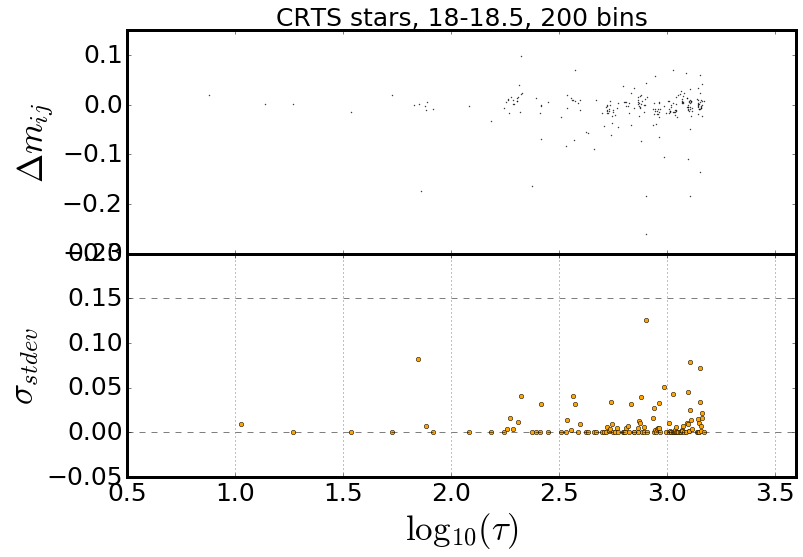

In [316]:
# Bin along time, and then plot all else ... 


import colorcet as cc
from matplotlib.colors import ListedColormap
#cmap = ListedColormap(cc.colorwheel)
cmap = 'cubehelix'
%matplotlib inline
obj =  'stars' # qso' #'stars' # qso' #  # QSO 
Min = 18
t1 = detail_dic[obj][Min]['t1']
t2 = detail_dic[obj][Min]['t2']
tau = detail_dic[obj][Min]['tau']
e_ij = detail_dic[obj][Min]['ei']
m_ij = detail_dic[obj][Min]['xi']

# first binning  : along time (t1) 
bin_size_days = 10
nbins_t  =int((max(t1) - min(t1)) / bin_size_days )  
print('Selecting days to be on average %d days wide, we end up with %d bins'%(bin_size_days, nbins_t))

tau_binned = binned_statistic(t1, tau, statistic='mean', bins=nbins_t)[0]
mij_binned = binned_statistic(t1, m_ij, statistic='mean', bins=nbins_t)[0]

# remove nans 
m1 = np.bitwise_not(np.isnan(tau_binned))
m2 = np.bitwise_not(np.isnan(mij_binned))
m = m1 * m2 

std = lambda x : np.std(x)

# second binning : along delta_t 
nbins = 200 
bin_stdev = binned_statistic(tau_binned[m], mij_binned[m], statistic = std, bins=nbins)[0]
mean_tau =  binned_statistic(tau_binned[m], tau_binned[m] , statistic='mean', bins=nbins)[0]


# plotting
m=abs(mij_binned)<2

xdata = np.log10(tau_binned[m])
ydata =  mij_binned[m]
#H, xedges, yedges = np.histogram2d(xdata,ydata, bins=nbins)
#H = np.rot90(H)
#H = np.flipud(H)
# Mask zeros
#Hmasked = np.ma.masked_where(H==0,H) 

# Plot 2D histogram using pcolor
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,8), sharex=True)
#image  = ax1.pcolormesh(xedges,yedges,np.log10(Hmasked), cmap=cmap)
ax1.scatter(xdata, ydata, s=0.15)
#colorbar = plt.colorbar(image)
#colorbar.set_label(r'$\log_{10}{\mathrm{(count)}}$', fontsize=20)

# set all plot parameters
lh_w   = 1.0  # horizontal line thickness 
lh_st  = '--' # horizontal line style 
lh_al  = 0.5  # horizontal line alpha parameter 
xmin, xmax = 0.5, 3.6
ymin, ymax = -0.05, 0.2

ax1.set_ylabel(r'$\Delta m_{ij}$')
ax1.set_title('CRTS '+obj+', '+str(Min)+'-'+str(Min+0.5)+', '+str(nbins)+' bins', fontsize=25)
ax1.set_xlim(xmin,xmax)

ax2.scatter(np.log10(mean_tau), bin_stdev,lw=0.5,c='orange')
ax2.set_xlabel(r'$\log_{10}(\tau)$')
ax2.set_ylabel(r'$\sigma_{stdev}$')
ax2.set_xlim(xmin,xmax)
ax2.axhline(y=0.0, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax2.axhline(y=0.15, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax2.axhline(y=0.2, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax2.grid(axis='x')
ax2.set_ylim(ymin, ymax)

fig.subplots_adjust(hspace=0)

#plt.tight_layout()
plt.savefig(outDir+'Fig_2_binned_data_'+obj+'_'+str(Min)+'-'+str(Max)+'_'+str(nbins)+'-bins.png')



In [254]:
outDir

'/Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-04-19/'

## 1) Use detailed master files, calculate stats for triangle plots, etc. 

In [3]:
########################################################################
# Read detail_dic  using the code above : reproduced here for clarity 
########################################################################

outDir = '../data_products/Fig_2_data/2017-04-19/'

Min_arr = [ 18,   18.5 ]
Max_arr = [ 18.5, 19   ]

# Load the files if needed later ....
detail_dic = {}
for obj in ['qso', 'stars'] : 
    detail_dic[obj] = {}
    
    for i in range(len(Min_arr)) : 
        Min = Min_arr[i]
        Max = Max_arr[i]
        detail_dic[obj][Min] = np.load(outDir + obj+'_' +str(Min)+'-'+str(Max)+'.npy').item()
        
print('Read detailed xi, ei data from %s'%outDir)

Read detailed xi, ei data from ../data_products/Fig_2_data/2017-04-19/


In [4]:
# Make a new dir ... 
# Set a directory to save the results...
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_2_data', 
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
                      
print('Today we will save our Fig_2 files in %s'%outDir)

Today we will save our Fig_2 files in /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-05-04/


In [392]:
######################################################
# Calculate the statistics in t1-t2  binning...
######################################################

# Plot the t1 vs t2... 
Min =  18
Max = Min + 0.5 

obj = 'qso' # stars'  # 'qso' ##'qso'
pre = {'qso':'QSO', 'stars':'Stars'}

x = detail_dic[obj][Min]['t1']
y = detail_dic[obj][Min]['t2']
z = detail_dic[obj][Min]['xi']


# Calculate  2D statistics on  t2-t1 bins ... 
bin_size_days = 20
nbins = int((max(x) - min(x)) / bin_size_days )  
print('bin_size= %d days,   nbins = %d '%(bin_size_days, nbins))

sigmaG = lambda x : 0.7413 *(np.percentile(x,75) - np.percentile(x,25))
z_sigmaG_stat = binned_statistic_2d(x, y, values = z, statistic=sigmaG, bins=nbins)
#z_sigmaG = z_sigmaG_stat[0].flatten()

z_count_stat = binned_statistic_2d(x, y, values = z, statistic='count', bins=nbins)
#z_count = z_count_stat[0].flatten()

z = y-x 
z_t2t1_stat = binned_statistic_2d(x, y, values = z, statistic='mean', bins=nbins)
#z_t2t1 = z_t2t1_stat[0].flatten()
print('Done calculating stats... ')

# Since it takes a while, save the results of this calculation ....
result_dic = {'z_mean_t2t1_stat':z_t2t1_stat,  'z_count_stat':z_count_stat ,  'z_sigG_xi_stat':z_sigmaG_stat}
fname  = outDir+ obj + '_'+str(Min)+'-'+str(Max)+'_'+str(bin_size_days)+'-day_'+str(nbins)+'-bins'
print('Saved to %s the detailed results of binned_statistic 2d, \
where 0 is the statistic, 1 is the edges, and 2 is the allocation '%fname)
np.save(fname , result_dic)

bin_size= 20 days,   nbins = 153 
Done calculating stats... 
Saved to /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-04-27/qso_18-18.5_20-day_153-bins the detailed results of binned_statistic 2d, where 0 is the statistic, 1 is the edges, and 2 is the allocation 


## 2) Make triangle corner plots ... 

In [2]:
# Read in the appropriate results....
# from the last time they were calculated...

outDir = '/Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-04-27/'
results = {}

bin_size_days = 20
nbins = 153

for obj in ['qso','stars'] : 
    results[obj] = {}
    for Min in [18,18.5]:
        Max = Min + 0.5
        fname  = outDir+ obj + '_'+str(Min)+'-'+str(Max)+'_'+str(bin_size_days)+'-day_'+str(nbins)+'-bins.npy'
        # read in the results ... 
        results[obj][Min] =  np.load(fname).item()

    

In [3]:
import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (500,-1))


In [4]:
# Make a new dir ... 
# Set a directory to save the results...
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_2_data', 
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
                      
print('Today we will save our Fig_2 files in %s'%outDir)

Today we will save our Fig_2 files in /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-05-04/


Saved as /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-05-03/Stars_18-18.5_t1-t2_count_20_days.png
Saved as /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-05-03/Stars_18-18.5_t1-t2_sigmaG_20_days.png


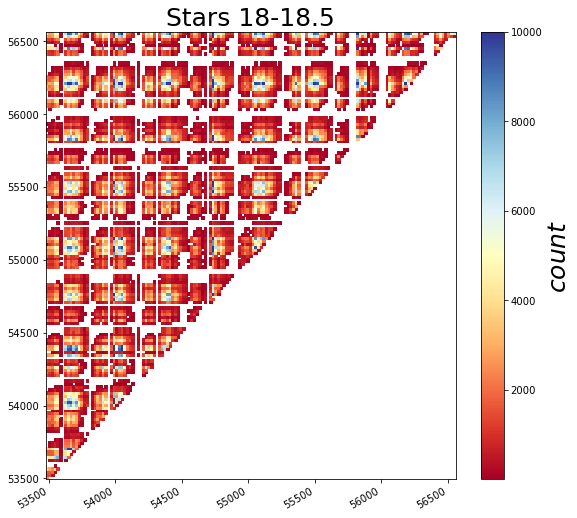

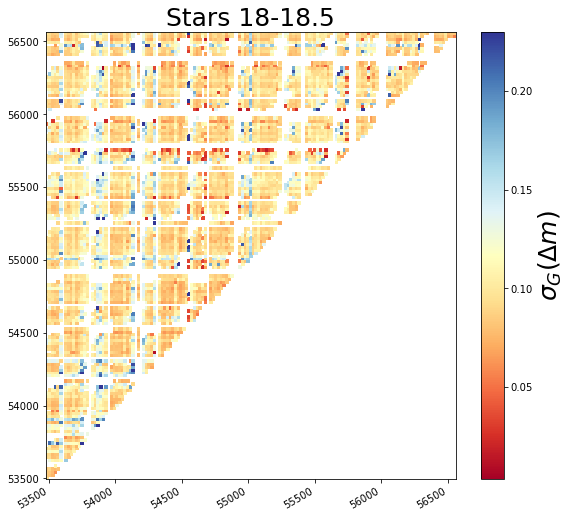

In [26]:
%matplotlib inline
# Triangle corner plots ...
# For all objects and cuts at the same time :)

pre = {'qso':'QSO', 'stars':'Stars'}

# plot only stars, change the colorscheme ... 
obj = 'stars' # for obj in ['qso', 'stars']:
Min = 18 #     for Min in [18, 18.5] : 
Max = Min + 0.5 

# plot 1 :  t1 vs t2 colored by  count 
#stats = binned_statistic_2d(x, y, values = z, statistic='count', bins=nbins)
z_count_stat = results[obj][Min]['z_count_stat']
z_sigma, x_edges, y_edges = z_count_stat[0], z_count_stat[1], z_count_stat[2]
# replace all nan's by 0 ...
z_sigma[np.isnan(z_sigma)] =0
z_reduce  =  z_sigma # [:-1, :-1] no need to reduce here because x_edges are already given with the right size
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display...
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros...

# Plot 2D histogram using pcolor
fig,ax = plt.subplots(1,1, figsize=(8,7))
cm = plt.cm.get_cmap('RdYlBu')
image = ax.pcolormesh(x_edges,y_edges,z_masked, cmap=cm, vmax=10000)  # np.log10(z_masked) gives log counts
fig.autofmt_xdate()
plt.tight_layout()
colorbar = fig.colorbar(image, ax = ax,  orientation='vertical')
colorbar.set_label(r'$count$', fontsize=25)

ax.set_title(pre[obj]+' '+str(Min)+'-'+str(Min+0.5), fontsize=25)
title = pre[obj]+'_'+str(Min)+'-'+str(Max)+'_t1-t2_count_'+str(bin_size_days)+'_days.png'
plt.savefig(outDir + title, bbox_inches='tight')
print('Saved as %s'%(outDir+title))


# plot 2 :  t1 vs t2 colored by  sigmaG(xi) per bin 

#stats = binned_statistic_2d(x, y, values = z, statistic=func, bins=nbins)
z_sigmaG_stat = results[obj][Min]['z_sigG_xi_stat']
z_sigma, x_edges, y_edges = z_sigmaG_stat[0], z_sigmaG_stat[1], z_sigmaG_stat[2]
# replace all nan's by 0 ...
z_sigma[np.isnan(z_sigma)] =0
z_reduce  =  z_sigma # [:-1, :-1] no need to reduce here because x_edges are already given with the right size
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display...
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros...

# Plot 2D histogram using pcolor
fig,ax = plt.subplots(1,1, figsize=(8,7))
image = ax.pcolormesh(x_edges,y_edges,z_masked, cmap=cm, vmax=0.23)  # np.log10(z_masked) gives log counts
fig.autofmt_xdate()
plt.tight_layout()
colorbar = fig.colorbar(image, ax = ax,  orientation='vertical')
colorbar.set_label(r'$\sigma_{G}(\Delta m)$', fontsize=25)

ax.set_title(pre[obj]+' '+ str(Min)+'-'+str(Min+0.5), fontsize=25)
title = pre[obj]+'_'+str(Min)+'-'+str(Max)+'_t1-t2_sigmaG_'+str(bin_size_days)+'_days.png'
plt.savefig(outDir + title, bbox_inches='tight')
print('Saved as %s'%(outDir+title))





## Test unravelling the indices 

Test 1 : simulated data

In [93]:
# To make sure : test that the 'by hand' way of unraveling indices from Jake VdP  
# # following https://github.com/scipy/scipy/issues/5449
# works in the same way as expand_binnumbers = True  in more recent
# scipy versions...

from scipy.stats import binned_statistic_2d

x = np.random.random(100)
y = np.arange(100)
z = np.arange(100)+2

stats1 = binned_statistic_2d(x,y,z, statistic='mean', bins=5)
x_ind, y_ind = np.unravel_index(stats1.binnumber,
                                (len(stats1.x_edge) + 1, len(stats1.y_edge) + 1))

stats2 = binned_statistic_2d(x,y,z, statistic='mean', bins=5, expand_binnumbers=True)

assert np.sum(stats2.binnumber[0] == x_ind) == len(x_ind)

Test 2:  real data 

In [94]:
# Real  data test : 
# take data from qso's in bin 18-18.5 that have already been binned into 153x153 pixels. 
# find out  the coordinates of pixel to which the raw data were binned . 
# Select a pixel,  and grab the raw xi data that went into it
# Compute sigmaG for these points 
# Compare to the value of sigmaG of that pixel : should be the same! 

obj = 'qso'
Min = 18
stats = results[obj][Min]['z_sigG_xi_stat']

# what is the x,y coordinate of pixel to which given raw data went , 
# binned  along t1 and t2 
x_pixel, y_pixel = np.unravel_index(stats.binnumber,
                                (len(stats.x_edge) + 1, len(stats.y_edge) + 1))

# this is the xi data that was originally binned along t1, t2  : 
raw_xi = detail_dic[obj][Min]['xi']

# check what xi data went into  bin number (1,1) : 
x_bin_number = 1
y_bin_number = 1 

mask = (x_pixel == x_bin_number) * (y_pixel  == y_bin_number)

# compute sigmaG for points in that bin ....
print('These should be identical:')
sigmaG = lambda x : 0.7413 *(np.percentile(x,75) - np.percentile(x,25))
sigG_1 = sigmaG(raw_xi[mask])
print('sigmaG for raw points in that bin is %f '% sigG_1)

# compare with calculated sigmaG : 
# bins are counted from 1, but indices into bins from 0 ... that's why  -1 
sigG_2 = stats.statistic[x_bin_number-1, y_bin_number-1]
print('sigmaG for thix pixel is %f '%sigG_2 )
assert sigG_1 == sigG_2
# Everything works !  :) 

These should be identical:
sigmaG for raw points in that bin is 0.088066 
sigmaG for thix pixel is 0.088066 


Test 2a : real data, with more verbose output: 

In [95]:
# construct indices into flattened array
ravel_indices = np.arange(np.ravel(stats[0]).shape[0])

# figure out which 2d bin each element came out ...
nbins = 153
unravel_indices = np.unravel_index(ravel_indices, (nbins, nbins))


# Here we show that when this stats are flattened, we can 
# recover the flattened index of the chosen result...

z_sigmaG = np.ravel(results[obj][Min]['z_sigG_xi_stat'][0])
z_mean_t2t1 = results[obj][Min]['z_mean_t2t1_stat'][0].flatten()

# Say we want to find out where the smallest value of mean(t2-t1) came from  : 

# 1) Find mask that  seeks to find where z_mean_t2t1 is equal to this value :  
print('1) We seek index for mean(t2-t1) = %f'%min(z_mean_t2t1))
mask_indices = np.where(z_mean_t2t1 == min(z_mean_t2t1))[0]

# 2) Show that this mask recovers the sought value  
print('2) Applying this mask to mean(t2-t1) yields %f : should be same as in 1)! ' % z_mean_t2t1[mask_indices][0])

# 3) What is the value of sigmaG for this mean(t2-t1) bin ? 
print('3) For this mean(t2-t1) bin, the value of sigmaG is %f'%z_sigmaG[mask_indices][0])

# 4) What is the corresponding index into flattened array ? 
flat_array_index = ravel_indices[mask_indices][0]
print('4) The index at which mean(t2-t1) has this value is %d'%flat_array_index )

# 5) Given the unravelled indices, which (x,y) indices  this 1d index correspond to ? 
x_index = unravel_indices[0][flat_array_index]
y_index = unravel_indices[1][flat_array_index]
print('5) x_index = %d, y_index = %d' % (x_index, y_index))

# 6) Indices start from 0 whereas bins from 1,  so find out which bins this corresponds to...
x_bin_choice , y_bin_choice = x_index + 1,  y_index +1
print('6) x_bin = %d, y_bin = %d'%(x_bin_choice, y_bin_choice))


# 7) Find which xi points were assigned to these bins : 
mask = (x_bin_number == x_bin_choice) * (y_bin_number  == y_bin_choice)
print('7) %d initial xi points were assigned to this bin' % np.sum(mask))

# 8) Compute sigmaG for these xi points, to confirm that it agrees with the value above : 
print('8) For these xi points, sigmaG(xi) = %f : should be the same as in 3)'%sigmaG(z[mask]))

1) We seek index for mean(t2-t1) = 0.653167
2) Applying this mask to mean(t2-t1) yields 0.653167 : should be same as in 1)! 
3) For this mean(t2-t1) bin, the value of sigmaG is 0.065679
4) The index at which mean(t2-t1) has this value is 20635
5) x_index = 134, y_index = 133
6) x_bin = 135, y_bin = 134
7) 0 initial xi points were assigned to this bin
8) For these xi points, sigmaG(xi) = 0.000000 : should be the same as in 3)


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:47: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future


Calculate which raw points went into each pixel. Then given which pixels went into rebinning, calculate sigmaG for raw points in pixels that are in a given rebin.

In [96]:
# define the sample
obj = 'qso'
Min = 18

# the raw data : delta_t and  delta_mag ...
t = detail_dic[obj][Min]['tau']
z = detail_dic[obj][Min]['xi']

# the results of :
# x = detail_dic[obj][Min]['t1']
# y = detail_dic[obj][Min]['t2']
# nbins  = 153 
# binned_statistic_2d(x, y, values = z, statistic=sigmaG, bins=nbins)
pixel_stats = results[obj][Min]['z_sigG_xi_stat']

# this tells us what is the x,y coordinate of bin to which given xi data went , binned 
# along t1 and t2 
# these are the same length as len(t),  and len(z):
# len(x_pixel) == len(y_pixel) == len(t)  == len(z)
x_pixel, y_pixel = np.unravel_index(pixel_stats.binnumber, 
                                              (len(pixel_stats.x_edge) + 1, 
                                               len(pixel_stats.y_edge) + 1))
# First binning : bin the pixel values
# Here we take the sigmaG, and mean_t2t1, binned along t2-t1 
z_sigmaG = np.ravel(results[obj][Min]['z_sigG_xi_stat'].statistic)
z_mean_t2t1 = np.ravel(results[obj][Min]['z_mean_t2t1_stat'].statistic)
z_count = np.ravel(results[obj][Min]['z_count_stat'].statistic)

# construct indices into flattened array
ravel_indices = np.arange(z_sigmaG.shape[0])

# figure out which 2d bin each element came out ...
nbins = 153
unravel_indices = np.unravel_index(ravel_indices, (nbins, nbins))


# Here we mask nan pixels 
mask_nans = np.bitwise_not(np.isnan(z_mean_t2t1))

# I'm re-binning the pixels
stats_1d = binned_statistic(z_mean_t2t1[mask_nans], z_sigmaG[mask_nans], 
                            statistic='median', bins=200)

sigmaG_pixel_raw = np.zeros_like(stats_1d[0])
mean_tau_pixel_raw = np.zeros_like(stats_1d[0])
count_pixel_raw = np.zeros_like(stats_1d[0])
# loop over all re-bins .... 1  to 200
for N in np.sort(np.unique(stats_1d.binnumber)):
    #print(N)
    flat_indices = ravel_indices[mask_nans][stats_1d.binnumber == N ]

    # Find which 2d  original indices this corresponds to ...
    x_index = unravel_indices[0][flat_indices]
    y_index = unravel_indices[1][flat_indices]

    # convert indices to bin numbers ...
    x_bin_choice , y_bin_choice = x_index + 1,  y_index +1
    
    # find out which bins initially end up now in rebin #1 ..
    mask = np.in1d(x_pixel , x_bin_choice) * np.in1d(y_pixel, y_bin_choice) 
    sigmaG_pixel_raw[N-1] = sigmaG(z[mask])
    mean_tau_pixel_raw[N-1]  = np.mean(t[mask])
    count_pixel_raw[N-1] = len(t[mask])
print('Done')

Done


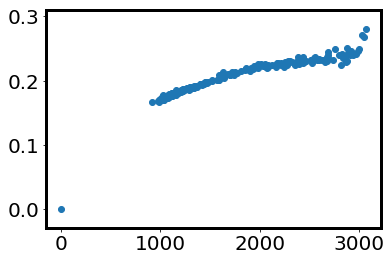

In [111]:
plt.scatter(mean_tau_pixel_raw, sigmaG_pixel_raw)

In [107]:
tau = np.ravel(results[obj][Min]['z_mean_t2t1_stat'].statistic)
m = np.bitwise_not(np.isnan(tau))
print(len(tau[m]))

delta = np.zeros_like(tau)
for j in range(len(tau)-1):
    delta[j] = np.sort(tau)[j+1] - np.sort(tau)[j]

7076


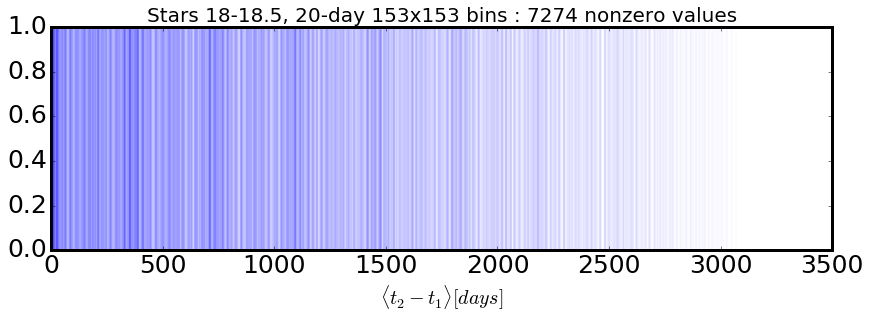

In [767]:
# display the frequency of t2-t1 : 
# how it is not necessarily regular, as binning in 
# the same number of bins of t2-t1 would be .... 

fig, ax = plt.subplots(1,1, figsize=(14,4))
for x in tau : 
    ax.axvline(x, lw=0.02)
    

title = pre[obj]+' '+str(Min)+'-'+str(Min+0.5)+', 20-day 153x153 bins : '          +str(len(tau)) + ' nonzero values'

ax.set_title(title, fontsize=20)
ax.set_xlabel(r'$\langle t_{2}-t_{1} \rangle [days]$', fontsize=20)
fname = outDir + pre[obj]+'_'+str(Min)+'-'+str(Min+0.5) + '_t2-t1_frequency_plot.png'
plt.savefig(fname, bbox_inches='tight')

## Plot the diagnostic multipanel plots ... 

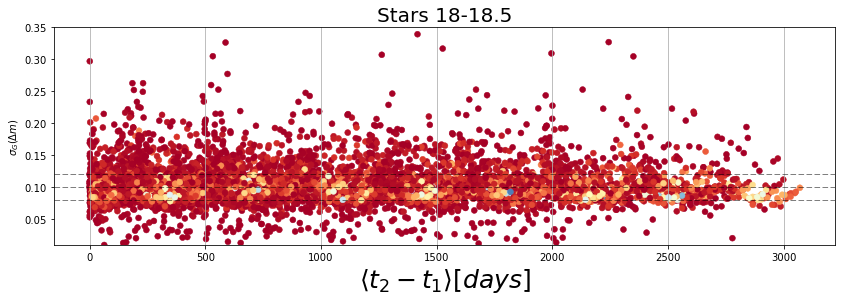

In [8]:
%matplotlib inline
# Plot just  sigmaG  vs  mean(t2 - t1 ) : 
pre = {'qso':'QSO', 'stars':'Stars'}
cm = plt.cm.get_cmap('RdYlBu')
obj = 'stars'
Min = 18 
Max = Min + 0.5
z_mean_t2t1 = results[obj][Min]['z_mean_t2t1_stat'][0].flatten()
z_sigmaG_xi = results[obj][Min]['z_sigG_xi_stat'][0].flatten()
z_count = results[obj][Min]['z_count_stat'][0].flatten()

fig, ax1 = plt.subplots(1,1, figsize=(14,4), sharex=True)
sc = ax1.scatter(z_mean_t2t1, z_sigmaG_xi, lw=0.5, c = z_count , s=35, cmap=cm)  # z_count 

# plot sigmaG  of delta_mag, previously binned 
ax1.set_title(pre[obj]+' '+str(Min)+'-'+str(Min+0.5), fontsize=20)
ax1.set_ylabel(r'$\sigma_{G}(\Delta m)$')
ax1.set_ylim(0.01,0.35)
ax1.set_xlabel(r'$\langle t_{2}-t_{1} \rangle [days]$', fontsize=25)

for ax in [ax1] : 
    ax.grid(axis='x')
    for y in [0.08,0.1,0.12]:
        ax.axhline(y=y, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)

title = pre[obj] +'_'+str(Min)+'-'+str(Max)+'_sigmaG-t2t1_'+str(bin_size_days)+'_days_top_panel.png'

plt.savefig(outDir+title,  bbox_inches='tight')


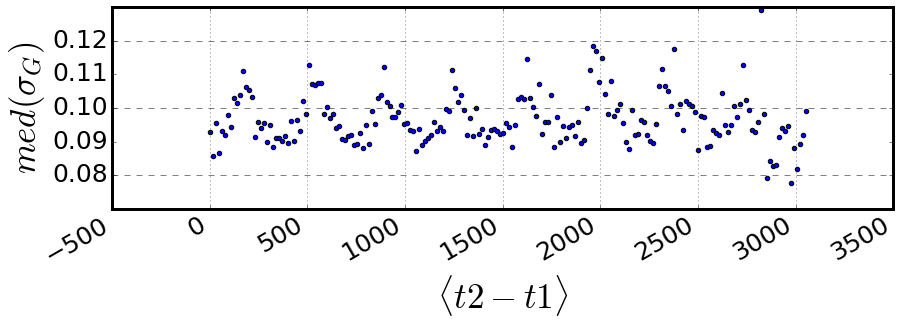

In [780]:
# Plot just middle panel   :  median  (sigmaG ) : 

obj = 'stars'
Min = 18 
z_mean_t2t1 = results[obj][Min]['z_mean_t2t1_stat'][0].flatten()
z_sigmaG_xi = results[obj][Min]['z_sigG_xi_stat'][0].flatten()
z_count = results[obj][Min]['z_count_stat'][0].flatten()

fig, ax2 = plt.subplots(1,1, figsize=(14,4))

# plot mean(sigmaG)
mask_nans = np.bitwise_not(np.isnan(z_mean_t2t1))
stats2 = binned_statistic(z_mean_t2t1[mask_nans], z_sigmaG_xi[mask_nans], statistic='median', bins=200)
median_sigmaG = stats2[0]
mean_tau = stats2[1][:-1]

ymin, ymax = 0.07, 0.13

ax2.scatter( mean_tau , median_sigmaG)
ax2.set_xlabel(r'$\langle t2-t1  \rangle $')
ax2.set_ylabel(r'$ med(\sigma_{G})$')
ax2.set_ylim(ymin, ymax)
yticks = ax2.get_yticks()
ax2.set_yticks(yticks[1:-2]) 

fig.autofmt_xdate()
fig.subplots_adjust(hspace=0)

for ax in [ax2] : 
    ax.grid(axis='x')
    for y in [0.08,0.1,0.12]:
        ax.axhline(y=y, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)

title = pre[obj] +'_'+str(Min)+'-'+str(Max)+'_sigmaG-t2t1_'+str(bin_size_days)+'_days_mid_panel.png'

plt.savefig(outDir+title,  bbox_inches='tight')


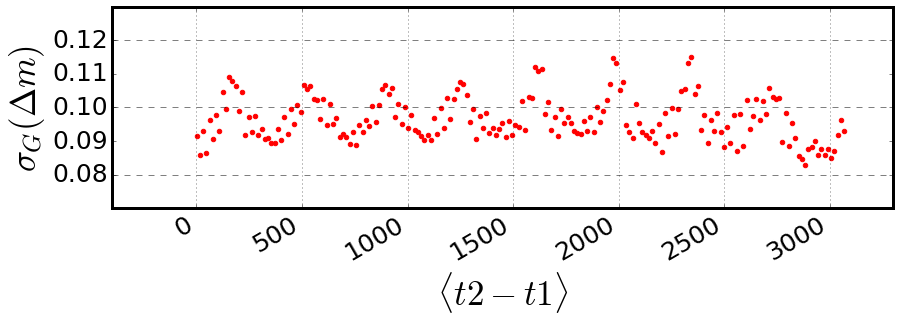

In [784]:
# Plot just the lower panel  : sigmaG  ( delta_mag)  of raw data ... 

obj = 'stars'
Min = 18 

fig, ax3 = plt.subplots(1,1, figsize=(14,4), sharex=True)

tau = detail_dic[obj][Min]['tau']
xi  = detail_dic[obj][Min]['xi']

sigmaG = lambda x : 0.7413 *(np.percentile(x,75) - np.percentile(x,25))
stats3 = binned_statistic(tau, xi, statistic=sigmaG, bins=200)
stats3_temp = binned_statistic(tau, tau, statistic='mean', bins=200)
mean_tau   = stats3_temp.statistic
bin_sigmaG = stats3.statistic

ax3.scatter(mean_tau,  bin_sigmaG, color='red')
ax3.set_ylim(ymin, ymax)
ax3.set_xlim(-400, 3300)
yticks = ax3.get_yticks()
ax3.set_yticks(yticks[1:-2]) 
ax3.set_ylabel(r'$\sigma_{G}(\Delta m)$')
ax3.set_xlabel(r'$\langle t2-t1  \rangle $')

fig.autofmt_xdate()
fig.subplots_adjust(hspace=0)

for ax in [ax1,ax2,ax3,ax4] : 
    ax.grid(axis='x')
    for y in [0.08,0.1,0.12]:
        ax.axhline(y=y, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)

title = pre[obj] +'_'+str(Min)+'-'+str(Max)+'_sigmaG-t2t1_'+str(bin_size_days)+'_days_raw.png'
plt.savefig(outDir+title,  bbox_inches='tight')

In [55]:
import matplotlib 
from matplotlib import rcParams
#matplotlib.rcParams['font.size'] = 17

#matplotlib.rc('xtick', labelsize=15) 
#matplotlib.rc('ytick', labelsize=15) 
rcParams['ytick.labelsize'] = 20
rcParams['xtick.labelsize'] = 20
rcParams['axes.labelsize'] = 25
rcParams['axes.linewidth'] = 3
rcParams['font.size'] = 25

In [12]:
results[obj][18.5]['z_mean_t2t1_stat'][0].flatten()

array([ 15.41684675,  38.16355798,  62.47547834, ...,          nan,
         1.01611971,  13.6010559 ])

Saved as ../data_products/Fig_2_data/2017-04-19/Stars_18.5-19.0_count-t2t1_20_days_mid_panel.png


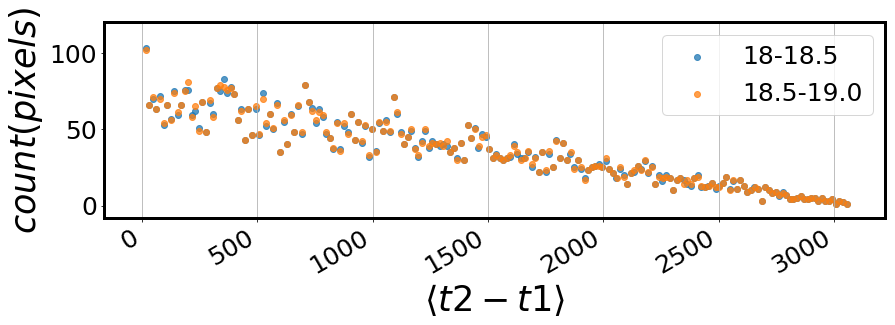

In [26]:
# Plot number of pixels per bin (when doing the median(sigmaG)) : 
# set all plot parameters
lh_w   = 1.0  # horizontal line thickness 
lh_st  = '--' # horizontal line style 
lh_al  = 0.5  # horizontal line alpha parameter 

# dot size 
p_size = 14 # 7
p_al   = 0.5 

# y limits for sigma, sigma_G, SF panels 
y_top  = 0.45
y_bott = -0.05

# y limits for mu approx 
y_mu_top = 0.1
y_mu_bott = -0.1

# x limits for ALL PANELS 
x_left = 0.5
x_right = 3.7

obj = 'stars'
fig, ax2 = plt.subplots(1,1, figsize=(14,4))

for Min in [18,18.5]:
    Max = Min + 0.5
    z_mean_t2t1 = results[obj][Min]['z_mean_t2t1_stat'][0].flatten()
    z_sigmaG_xi = results[obj][Min]['z_sigG_xi_stat'][0].flatten()

    # plot mean(sigmaG)
    mask_nans = np.bitwise_not(np.isnan(z_mean_t2t1))  # leaves the ~7000 nonzero bins....
    stats2 = binned_statistic(z_mean_t2t1[mask_nans], z_sigmaG_xi[mask_nans], 
                              statistic='median', bins=200)
    stats2_temp = stats2 = binned_statistic(z_mean_t2t1[mask_nans], z_mean_t2t1[mask_nans], 
                              statistic='mean', bins=200)
    median_sigmaG = stats2.statistic
    mean_tau = stats2_temp.statistic
    
    value, count = np.unique(stats2.binnumber, return_counts=True)
    ax2.scatter( np.sort(mean_tau) , count,alpha=0.75, label=str(Min)+'-'+str(Max))
plt.legend(loc='best')
ax2.set_xlabel(r'$\langle t2-t1  \rangle $')
ax2.set_ylabel(r'$ count(pixels)$')
ax2.set_ylim(ymax = 120)
yticks = ax2.get_yticks()
ax2.set_yticks(yticks[1:-1]) 

fig.autofmt_xdate()
fig.subplots_adjust(hspace=0)

for ax in [ax2] : 
    ax.grid(axis='x')
   
title = pre[obj] +'_'+str(Min)+'-'+str(Max)+'_count-t2t1_'+\
        str(bin_size_days)+'_days_mid_panel.png'
plt.savefig(outDir+title,  bbox_inches='tight')
print('Saved as %s'%(outDir + title))


In [ ]:
# Plot how many raw points there is in pixels included in each t2-t1 bin : 

# I'd say need to figure out if unraveling works - it seems to , because I already tested it
# Document how I tested it to prove that it works well. 



Saved as /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-05-04/Stars_18.5-19.0_count_raw-t2t1_20_days_raw.png


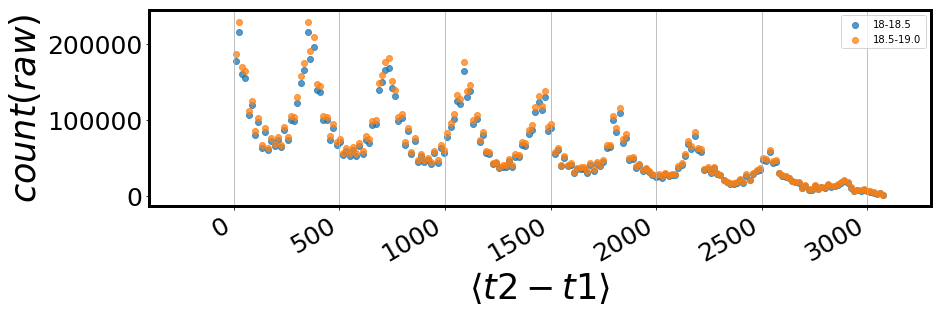

In [83]:
# For the raw points : plot the number of points per bin   of sigmaG( delta_mag )

obj = 'stars'
fig, ax3 = plt.subplots(1,1, figsize=(14,4), sharex=True)

for Min in  [18, 18.5] : 
    Max = Min + 0.5

    tau = detail_dic[obj][Min]['tau']
    xi  = detail_dic[obj][Min]['xi']

    sigmaG = lambda x : 0.7413 *(np.percentile(x,75) - np.percentile(x,25))
    stats3 = binned_statistic(tau, xi, statistic=sigmaG, bins=200)
    stats3_temp = binned_statistic(tau,tau,statistic='mean', bins=200)
    mean_tau   = stats3_temp.statistic
    value , count = np.unique(stats3.binnumber, return_counts=True)
    ax3.scatter(mean_tau,  count, alpha=0.75, label=str(Min)+'-'+str(Max))

plt.legend(loc='best')
#ax3.set_ylim(ymin, ymax)
ax3.set_xlim(-400, 3300)
yticks = ax3.get_yticks()
ax3.set_yticks(yticks[1:-1]) 
ax3.set_ylabel(r'$count (raw)$')
ax3.set_xlabel(r'$\langle t2-t1  \rangle $')

fig.autofmt_xdate()
fig.subplots_adjust(hspace=0)

for ax in [ax3] : 
    ax.grid(axis='x')
   
title = pre[obj] +'_'+str(Min)+'-'+str(Max)+'_count_raw-t2t1_'+\
        str(bin_size_days)+'_days_raw.png'
plt.savefig(outDir+title,  bbox_inches='tight')
print('Saved as %s'%(outDir + title))


### Make another panel : Appendix B figure 

"The motivation for the additional panel is that it seems to me that the oscillation
problem might not have anything to do with the actual sample size. It could be that
systematic photometric calibration errors are large when comparing data obtained
six months apart than for data obtained at the same time of year. To test this
hypothesis, I propose to redo the middle panel (sigmaG with raw measurements)
as the 6th panel where, instead of using all the data points when computing sigmaG,
you *randomly subselect* 20,000 points. This number comes from the bottom panel 
where I see that counts vary from about 200,000 to about 0. Choosing a random
sample of 20,000 points will allow you to get good results to beyond t2-t1 ~ 1500
and thus you should see (or not) the first four wiggles in sigmaG. I think that the
amplitude of sigmaG for the first four wiggles will remain about the same when you 
always use 20,000 random points (when you have fewer than 20,000 points, don’t
plot any points). This will demonstrate that the wiggles are not due to varying 
sample size. If the amplitude becomes much smaller instead, then I am wrong
about calibration problems and the oscillations are indeed caused (somehow)
by the varying sample size."  (Zeljko's email   5/4/17 )  



In [38]:
# Code to select a sample of xi , ei points, treating all 
# stars together ... 
# this is what makes  detail_dic{}

imp.reload(mod)

Min_arr = [17, 18,   18.5 ]
Max_arr = [18, 18.5, 19   ]

detail_dic = {}
detail_dic['qso'] = {}
detail_dic['stars'] = {}

mag = 'r'   # which magnitudes to use for cutting and reporting 
inDirStars   = '../data_products/sf_file_per_LC/stars/'
inDirQSO = '../data_products/sf_file_per_LC/qso_detailed/'
        

for i in range(len(Min_arr)):
    Min = Min_arr[i]
    Max = Max_arr[i]

    print('\nUsing now only lightcurves with SDSS  %f< %s < %f' % (Min, mag, Max))
     
    # no need for QSO to prove our point... 
    #detail_dic['qso'][Min] = mod.faster_read_xi_ei(inDirSF = inDirQSO, 
    #                                               good_ids= mod.cut_qso(qso_cat=qso_cat, mMin = Min, 
    #                                               mMax=Max, mErrMax = 0.3, cut_mag=mag), detailed=True)

    # we combine blue and red stars by choosing g-i from   -1 to 1 and 1 to 3 together 
    detail_dic['stars'][Min] = mod.faster_read_xi_ei(inDirSF =inDirStars,  
                               good_ids = mod.cut_stars(star_cat = star_cat, mMin = Min, 
                               mMax=Max, mErrMax = 0.3, gi_Min = -1, gi_Max=3, 
                               cut_mag=mag + '_mMed'), 
                               detailed=None)


    


Using now only lightcurves with SDSS  17.000000< r < 18.000000

Choosing stars with  SDSS   -1.00<g-i<3.00
 These cuts reduced the number of stars  in the sample from 48250 to 5790

Reading in tau,xi,ei  for 5790 objects

Using structure function master files from ../data_products/sf_file_per_LC/stars/
[##########] 100.00%
Finished reading all master files for the selected objects ...


In [41]:
list(detail_dic.keys())

['qso', 'stars']

In [ ]:
# Save the QSO, stellar detailed master files into bigger combined files.

for obj in detail_dic.keys(): 
    for i in range(len(Min_arr)) : 
        Min = Min_arr[i]
        Max = Max_arr[i]
        np.save(outDir + obj+'_' +str(Min)+'-'+str(Max) , detail_dic[obj][Min])

In [3]:
########################################################################
# Read detail_dic  using the code above : reproduced here for clarity 
########################################################################

outDir = '../data_products/Fig_2_data/2017-04-19/'

# Load the files if needed later ....
detail_dic = {}
for obj in ['qso', 'stars'] : 
    detail_dic[obj] = {}
    
    for i in range(len(Min_arr)) : 
        Min = Min_arr[i]
        Max = Max_arr[i]
        detail_dic[obj][Min] = np.load(outDir + obj+'_' +str(Min)+'-'+str(Max)+'.npy').item()
        
print('Read detailed xi, ei data from %s'%outDir)

Read detailed xi, ei data from ../data_products/Fig_2_data/2017-04-19/


In [10]:
# Make a new dir ... 
# Set a directory to save the results...
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_B1_data', 
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
                      
print('Today we will save our Fig_2 files in %s'%outDir)

Today we will save our Fig_2 files in /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-06-06/


In [18]:
import matplotlib 
from matplotlib import rcParams
#matplotlib.rcParams['font.size'] = 17
#matplotlib.rc('xtick', labelsize=15) 
#matplotlib.rc('ytick', labelsize=15) 
rcParams['ytick.labelsize'] = 25
rcParams['xtick.labelsize'] = 25
rcParams['axes.labelsize'] = 35
rcParams['axes.linewidth'] = 3
rcParams['font.size'] = 25

In [42]:
# Do random selection and calculating mean tau ... 
# So that plotting can be done separately with just 
# a small fraction of data ... 

#bin_size_days = 20
obj = 'stars'

plot_dic = {}

for Min , Max in zip([17,18,18.5], [18,18.5,19]):
    plot_dic[Min] = {}
    
    # read in the points 
    tau = detail_dic[obj][Min]['tau']
    xi  = detail_dic[obj][Min]['xi']

    # randomly  select points...
    # sigmaG (raw measurements ) : randomly subselect 20000 points 
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html 
    indices = np.arange(len(xi))
    size = 20000 

    # first split xi, tau into 200 bins  
    stats_temp = binned_statistic(tau, xi, statistic='count', bins=200)

    # go over each bin, and calculate the sigmaG(xi) using random resample of N points.
    sigmaG_xi = np.zeros_like(stats_temp.statistic)
    N_pts  = 20000

    sigmaG = lambda x : 0.7413 *(np.percentile(x,75) - np.percentile(x,25))

    for N in np.sort(np.unique(stats_temp.binnumber)): 
        xi_per_bin = xi[stats_temp.binnumber == N] # choose points in the N-th bin
        # randomly select 'N_pts'  from each bin. 
        # If there is less than N_pts in the bin,  then return NaN
        if len(xi_per_bin) >= N_pts : 
            # randomly select N_pts points, and make sure that each point 
            # is drawn only once ! 
            xi_sample = np.random.choice(xi_per_bin, size = N_pts, replace = False)
            sigmaG_xi[N-1] = sigmaG(xi_sample)
        else :  # if the number of points per bin is less than N_pts, then set 
            # the sigmaG to nan, or 0, or some other number. 
            sigmaG_xi[N-1] = np.nan 

    mean_tau = (stats_temp.bin_edges[:-1] + stats_temp.bin_edges[1:])/2
    bin_sigmaG = sigmaG_xi

    plot_dic[Min]['mean_tau'] = mean_tau
    plot_dic[Min]['bin_sigmaG'] = bin_sigmaG


In [45]:
plot_dic.keys()

dict_keys([17, 18, 18.5])

N bins with lt 20000 points : 16
N bins with lt 20000 points : 32
N bins with lt 20000 points : 32
Saved as /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-06-06/Stars_CRTS_wiggles.png


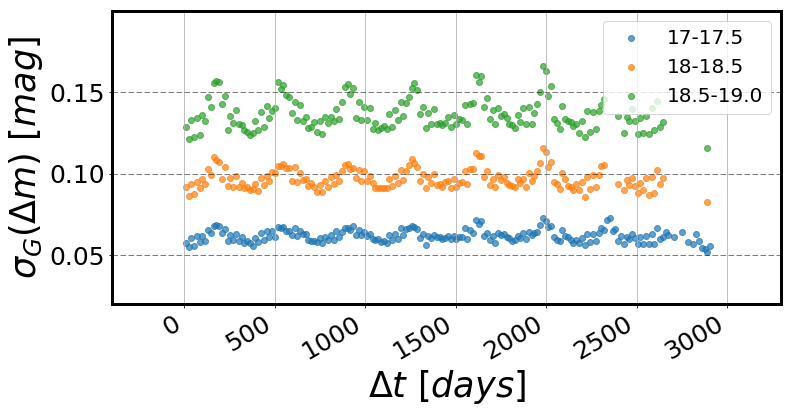

In [51]:
# The other idea : select randomly points  *within* the bin, so that the 
# count is always exactly 20000...
%matplotlib inline

fig, ax3 = plt.subplots(1,1, figsize=(12,6), sharex=True)

# set all plot parameters
lh_w   = 1.0  # horizontal line thickness 
lh_st  = '--' # horizontal line style 
lh_al  = 0.5  # horizontal line alpha parameter 

pre = {'qso':'QSO', 'stars':'Stars'}
cm = plt.cm.get_cmap('RdYlBu')

for Min in [17,18,18.5] : 
    print('N bins with lt 20000 points : %d'% np.sum(np.isnan(plot_dic[Min]['bin_sigmaG'])))
    ax3.scatter(plot_dic[Min]['mean_tau'],  plot_dic[Min]['bin_sigmaG'], 
                label = str(Min)+'-'+str(Min+0.5), alpha=0.7)
#ax3.set_title(pre[obj] + ' '+str(Min)+'-'+str(Max)+\
#              ', bin count =  '+str(N_pts) , fontsize=20 )
# plt.legend(loc='best')  

#if Min == 18 : 
#    ymin = 0.04
#elif Min == 18.5 :
#    ymin = 0.07    
dy = 0.13
ax3.set_ylim(0.02, ymin+dy)
#ax3.set_ylim(0.06, 0.17)
ax3.set_xlim(-400, 3300)
yticks = ax3.get_yticks()
ax3.set_yticks(yticks[1:-1]) 
ax3.set_ylabel(r'$\sigma_{G}(\Delta m)\,\,  [mag]$')
ax3.set_xlabel(r'$\Delta t \, \, [days]$')
plt.legend(loc='upper right', fontsize=20)

fig.autofmt_xdate()
fig.subplots_adjust(hspace=0)

for ax in [ax3] : 
    ax.grid(axis='x')
    for y in [0.05,0.1, 0.15]:
        ax.axhline(y=y, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)

title = pre[obj] +'_CRTS_wiggles.png'
plt.savefig(outDir+title,  bbox_inches='tight')
print('Saved as %s'%outDir+title)



In [49]:
outDir

'/Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-06-06/'

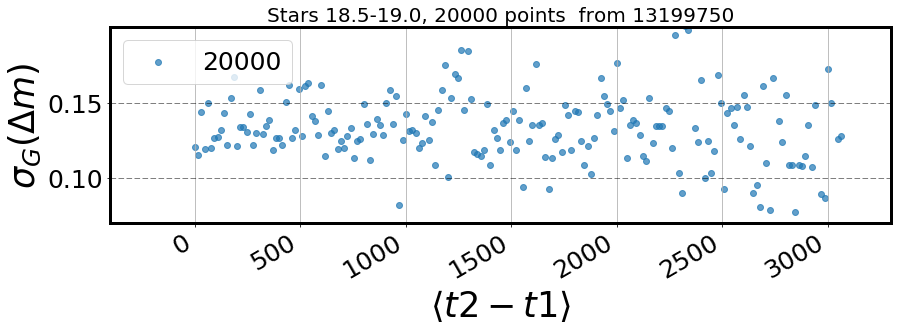

In [20]:
# Here I do something orthogonal to Zeljko's suggestion : 
# I randomly select 20000 points from ALL the points in the
# sample ... 


pre = {'qso':'QSO', 'stars':'Stars'}
cm = plt.cm.get_cmap('RdYlBu')
bin_size_days = 20
# set all plot parameters
lh_w   = 1.0  # horizontal line thickness 
lh_st  = '--' # horizontal line style 
lh_al  = 0.5  # horizontal line alpha parameter 

# sigmaG (raw measurements ) : randomly subselect 20000 points 
obj = 'stars'
Min = 18.5

fig, ax3 = plt.subplots(1,1, figsize=(14,4), sharex=True)

tau = detail_dic[obj][Min]['tau']
xi  = detail_dic[obj][Min]['xi']

# randomly  select points...
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html 
indices = np.arange(len(xi))

for size in [20000]:#  , 50000,  500000, int(1e6)] : 
    indices_sample = np.random.choice(indices, size=size, replace = False)
    # make sure we are only randomly choosing indices - pairs of  delta_mag vs delta_time
    # stay together... 
    xi_sample  = xi[indices_sample]
    tau_sample = tau[indices_sample]

    sigmaG = lambda x : 0.7413 *(np.percentile(x,75) - np.percentile(x,25))
    stats3 = binned_statistic(tau_sample, xi_sample, statistic=sigmaG, bins=200)
    mean_tau   = stats3.bin_edges[:-1]
    bin_sigmaG = stats3.statistic
    ax3.scatter(mean_tau,  bin_sigmaG, label = str(size), alpha=0.7)

ax3.set_title(pre[obj] + ' '+str(Min)+'-'+str(Max)+', '+ str(size)+\
              ' points  from ' + str(len(xi)), fontsize=20 )
plt.legend(loc='best')  
if Min == 18 : 
    ymin = 0.04
elif Min == 18.5 :
    ymin = 0.07
    
dy = 0.13
ax3.set_ylim(ymin, ymin+dy)
#ax3.set_ylim(0.06, 0.17)
ax3.set_xlim(-400, 3300)
yticks = ax3.get_yticks()
ax3.set_yticks(yticks[1:-1]) 
ax3.set_ylabel(r'$\sigma_{G}(\Delta m)$')
ax3.set_xlabel(r'$\langle t2-t1  \rangle $')

fig.autofmt_xdate()
fig.subplots_adjust(hspace=0)

for ax in [ax3] : 
    ax.grid(axis='x')
    for y in [0.1, 0.15]:
        ax.axhline(y=y, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)

title = pre[obj] +'_'+str(Min)+'-'+str(Max)+'_sigmaG-t2t1_'+\
    str(bin_size_days)+'_days_raw_sample1.png'
plt.savefig(outDir+title,  bbox_inches='tight')




Figure saved in /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-05-03/Stars_18.5-19.0_multipanel_20_days.png


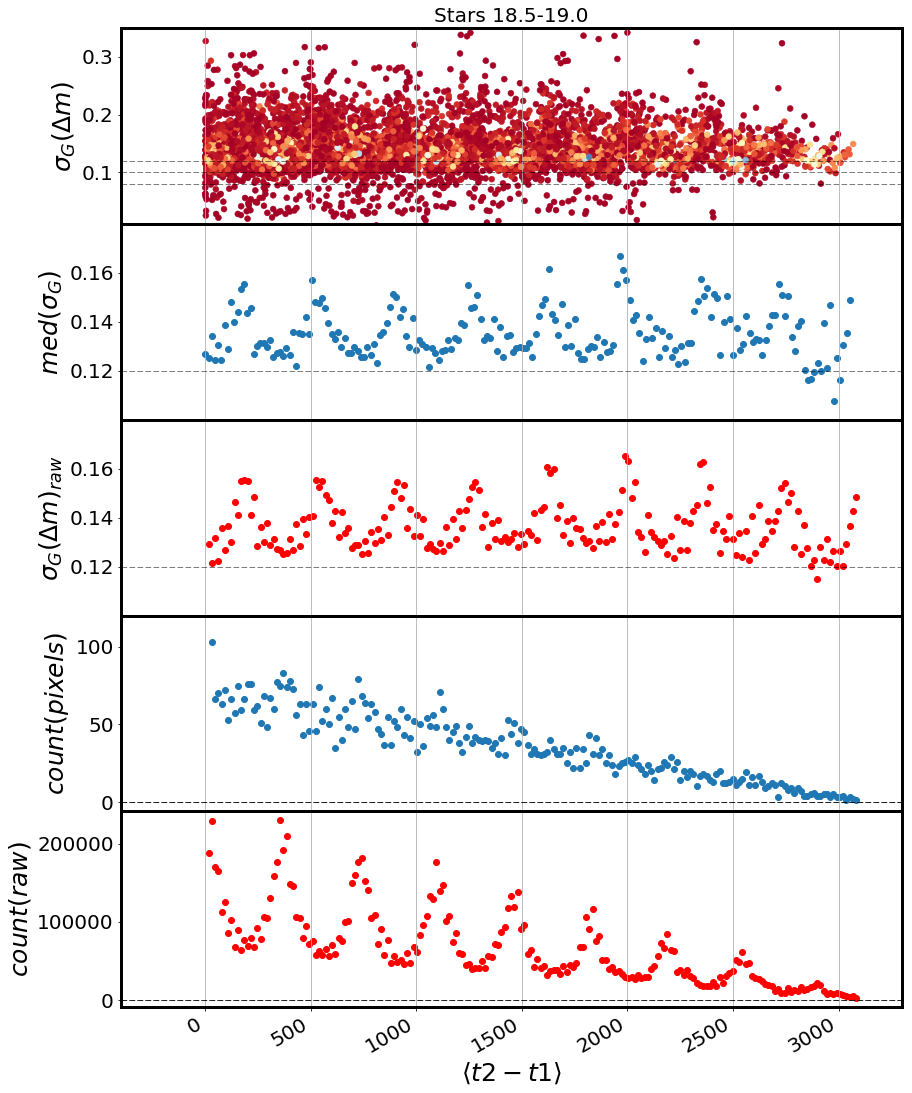

In [152]:
# Plot all panels together .... 

obj = 'stars'
Min = 18.5 
Max = Min + 0.5

z_mean_t2t1 = results[obj][Min]['z_mean_t2t1_stat'][0].flatten()
z_sigmaG_xi = results[obj][Min]['z_sigG_xi_stat'][0].flatten()
z_count = results[obj][Min]['z_count_stat'][0].flatten()

fig,(ax1,ax2, ax3,ax4,ax5) = plt.subplots(5,1, figsize=(14,20), sharex=True)
sc = ax1.scatter(z_mean_t2t1, z_sigmaG_xi, lw=0.5, c = z_count , s=35, cmap=cm)  # z_count 


###############
#  1st panel  #
###############

# plot sigmaG  of delta_mag, previously binned 
ax1.set_title(pre[obj]+' '+str(Min)+'-'+str(Max), fontsize=20)
ax1.set_ylabel(r'$\sigma_{G}(\Delta m)$')
ax1.set_ylim(0.01,0.35)

###############
#  2nd panel  #
###############

# plot mean(sigmaG)
mask_nans = np.bitwise_not(np.isnan(z_mean_t2t1))
stats2 = binned_statistic(z_mean_t2t1[mask_nans], z_sigmaG_xi[mask_nans], 
                          statistic='median', bins=200)
median_sigmaG = stats2.statistic
# need to calculate statistics so that instead of edges of bins, we calculate 
# the mean tau in the bin... 
stats2_temp = binned_statistic(z_mean_t2t1[mask_nans], z_mean_t2t1[mask_nans], 
                          statistic='mean', bins=200)
mean_tau = stats2_temp.statistic

ymin, ymax = 0.1, 0.18

ax2.scatter( mean_tau , median_sigmaG)
ax2.set_xlabel(r'$\langle t2-t1  \rangle $')
ax2.set_ylabel(r'$ med(\sigma_{G})$')
ax2.set_ylim(ymin, ymax)
yticks = ax2.get_yticks()
ax2.set_yticks(yticks[1:-1]) 

################
#  3rd panel   #
################
# plot sigmaG of raw points binned along tau... 
obj = 'stars' 
tau = detail_dic[obj][Min]['tau']
xi  = detail_dic[obj][Min]['xi']

sigmaG = lambda x : 0.7413 *(np.percentile(x,75) - np.percentile(x,25))
stats3 = binned_statistic(tau, xi, statistic=sigmaG, bins=200)
bin_sigmaG = stats3.statistic

# temp for mean tau..
stats3_temp = binned_statistic(tau, tau, statistic='mean', bins=200)
mean_tau   = stats3_temp.statistic

ax3.scatter(mean_tau,  bin_sigmaG, color='red')
ax3.set_ylim(ymin, ymax)
ax3.set_xlim(-400, 3300)
yticks = ax3.get_yticks()
ax3.set_yticks(yticks[1:-1]) 
ax3.set_ylabel(r'$\sigma_{G}(\Delta m)_{raw}$')

################
#  4th panel   #
################

# count of pixels per bin 
bin_number, pixel_count = np.unique(stats2.binnumber, return_counts=True)

ax4.scatter( np.sort(mean_tau) , count)
#ax4.set_xlabel(r'$\langle t2-t1  \rangle $')
ax4.set_ylabel(r'$ count(pixels)$')
ax4.set_ylim(ymax = 120)
yticks = ax4.get_yticks()
ax4.set_yticks(yticks[1:-1]) 

################
#  5th panel   #
################

# count of raw points per bin
bin_number , raw_count = np.unique(stats3.binnumber, return_counts=True)

ax5.scatter(mean_tau, raw_count, color='red')
ax5.set_xlim(-400, 3300)
yticks = ax5.get_yticks()
ax5.set_yticks(yticks[1:-1]) 
ax5.set_ylabel(r'$count (raw)$')
ax5.set_xlabel(r'$\langle t2-t1  \rangle $')


fig.autofmt_xdate()
fig.subplots_adjust(hspace=0)

for ax in [ax1,ax2,ax3,ax4, ax5] : 
    ax.grid(axis='x')
    for y in [0.08,0.1,0.12]:
        ax.axhline(y=y, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)

title = pre[obj] +'_'+str(Min)+'-'+str(Max)+'_multipanel_'+str(bin_size_days)+'_days.png'
print('Figure saved in %s'%(outDir + title ))
plt.savefig(outDir+title,  bbox_inches='tight')

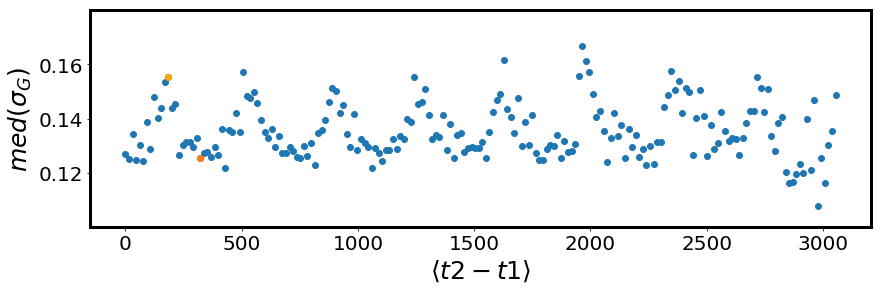

In [127]:
# Take a point from the maximum and from the minimum : compare what raw points end up in it ...

fig, ax2 = plt.subplots(1,1, figsize=(14,4), sharex=True)
# plot mean(sigmaG)
mask_nans = np.bitwise_not(np.isnan(z_mean_t2t1))
stats2 = binned_statistic(z_mean_t2t1[mask_nans], z_sigmaG_xi[mask_nans], 
                          statistic='median', bins=200)
median_sigmaG = stats2.statistic
mean_tau = stats2.bin_edges[:-1]

ymin, ymax = 0.1, 0.18

ax2.scatter( mean_tau , median_sigmaG)
x = 12
ax2.scatter(mean_tau[x], median_sigmaG[x], c='orange')
x = 21
ax2.scatter(mean_tau[x], median_sigmaG[x])
ax2.set_xlabel(r'$\langle t2-t1  \rangle $')
ax2.set_ylabel(r'$ med(\sigma_{G})$')
ax2.set_ylim(ymin, ymax)
yticks = ax2.get_yticks()
ax2.set_yticks(yticks[1:-1]) 

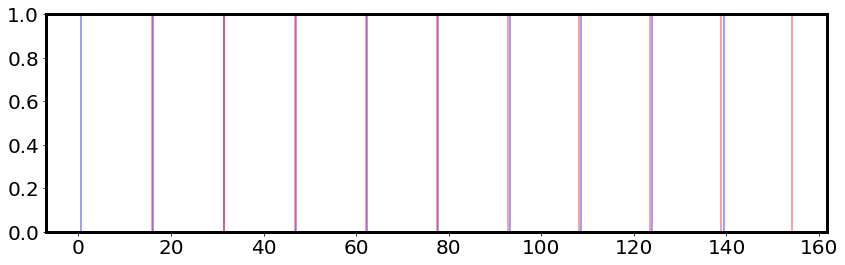

In [154]:
# the bin edges are not exactly the same ! 
# ?????????

fig,ax =  plt.subplots(1,1, figsize=(14,4), sharex=True)

for x in stats3.bin_edges[:-1][:10] : 
    ax.axvline(x, alpha=0.5, c='blue')
    
for x in stats2.bin_edges[1:][:10] : 
    ax.axvline(x, alpha=0.5, c='red')    
    

In [140]:
# Want to find out which points 

array([  6.52000000e-01,   1.60671240e+01,   3.14822480e+01,
         4.68973720e+01,   6.23124960e+01,   7.77276200e+01,
         9.31427440e+01,   1.08557868e+02,   1.23972992e+02,
         1.39388116e+02,   1.54803240e+02,   1.70218364e+02,
         1.85633488e+02,   2.01048612e+02,   2.16463736e+02,
         2.31878860e+02,   2.47293984e+02,   2.62709108e+02,
         2.78124232e+02,   2.93539356e+02,   3.08954480e+02,
         3.24369604e+02,   3.39784728e+02,   3.55199852e+02,
         3.70614976e+02,   3.86030100e+02,   4.01445224e+02,
         4.16860348e+02,   4.32275472e+02,   4.47690596e+02,
         4.63105720e+02,   4.78520844e+02,   4.93935968e+02,
         5.09351092e+02,   5.24766216e+02,   5.40181340e+02,
         5.55596464e+02,   5.71011588e+02,   5.86426712e+02,
         6.01841836e+02,   6.17256960e+02,   6.32672084e+02,
         6.48087208e+02,   6.63502332e+02,   6.78917456e+02,
         6.94332580e+02,   7.09747704e+02,   7.25162828e+02,
         7.40577952e+02,

## 4) Plot the actual comparison of QSO and stars , as above 

### 4a)  calculate the stats (redo for 200, 150, 100, 50 bins) 

In [356]:
%matplotlib inline

# Check to make sure that delta t is the same as t2 - t1 ...

plot_data = {}
for obj in ['qso', 'stars']:
    plot_data[obj] = {}
    for Min in [18.5, 18] :
        
        x = detail_dic[obj][Min]['t1']
        y = detail_dic[obj][Min]['t2']
        tau = y-x  # detail_dic[obj][Min]['tau']
        e_ij = detail_dic[obj][Min]['ei']
        m_ij = detail_dic[obj][Min]['xi']

        nbins = 100 

        # Pull out some tau to plot means : common to all panels 
        binned_tau = binned_statistic(tau, tau, statistic='mean', bins=nbins)
        mean_tau = binned_tau[0]

        # Take N from each bin... 'count' function works like a regular histogram
        binned_count = binned_statistic(tau, tau, statistic='count', bins=nbins)
        bin_count = binned_count[0]


        # checking for empty bins : either mean or some custom function, but not
        # count! If statistic='count', then check for 0's , and not for nan's/ 
        non_empty_bins = np.bitwise_not(np.isnan(mean_tau))

        # reassign number of points in a bin and  tau position 

        bin_count = bin_count[non_empty_bins]
        mean_tau = mean_tau[non_empty_bins]

        ####
        ####  Panel 1 : Standard Deviation 
        ####

        rms_std = lambda x : np.std(x)
        stdev_binned = binned_statistic(tau, m_ij, statistic = rms_std, 
                                                  bins=nbins)
        bin_stdev = stdev_binned[0][non_empty_bins]  

        #####
        ##### Panel 2  : Gaussian rms  
        #####
        rms_robust = lambda x : 0.7414 *(np.percentile(x,75) - np.percentile(x,25))
        bin_sigma_G = binned_statistic(tau, m_ij, statistic = rms_robust, 
                                      bins=nbins)[0][non_empty_bins]

        plot_data[obj][Min] = {'meanTau' : mean_tau,   'stdev':bin_stdev, 'sigmaG':bin_sigma_G, 'binCount':bin_count}
print('Done')   

Done


### 4b) plot the two panels ... 

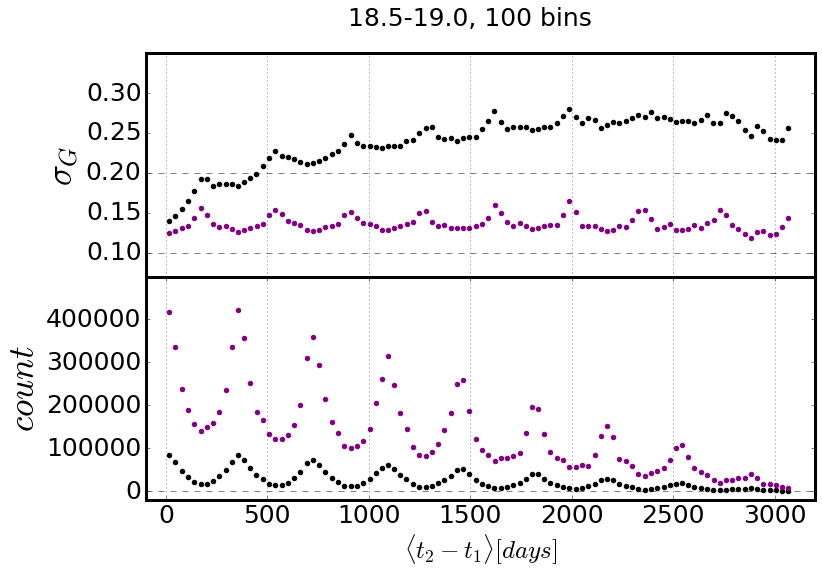

In [378]:
colors = {'qso': 'black',  'stars' : 'purple'}
# Plot ..
fig,ax = plt.subplots(2,1, figsize=(12,8), sharex=True)
Min = 18.5
Max = Min+0.5
# set all plot parameters
lh_w   = 1.0  # horizontal line thickness 
lh_st  = '--' # horizontal line style 
lh_al  = 0.5  # horizontal line alpha parameter 

# dot size 
p_size = 14 # 7
p_al   = 0.5 

# y limits for sigma, sigma_G, SF panels 
y_top  = 0.45
y_bott = -0.05

# y limits for mu approx 
y_mu_top = 0.1
y_mu_bott = -0.1

# x limits for ALL PANELS 
x_left = 0.5
x_right = 3.7


# PANEL 1 
for obj in plot_data.keys() : 
    ax[0].scatter(plot_data[obj][Min]['meanTau'], plot_data[obj][Min]['sigmaG'], color = colors[obj])
ax[0].set_ylabel(r'$\sigma_{G}$')    
ax[0].tick_params( axis='x', which='both',  bottom='off', 
                top='off', labelbottom='off') 
ax[0].set_ylim(0.07,0.35)
#ax[0].set_xlim(left=x_left, right=x_right)
#ax[0].set_yticks([0,0.1,0.2,0.3,0.4])
#ax[0].set_yticklabels(['0.0','0.1', '0.2', '0.3', '0.4'])
ax[0].axhline(y=0.0, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[0].axhline(y=0.1, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[0].axhline(y=0.2, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[0].grid(axis='x')

# PANEL 2
for obj in plot_data.keys() : 
    ax[1].scatter(plot_data[obj][Min]['meanTau'], plot_data[obj][Min]['binCount'], color = colors[obj])
ax[1].set_ylabel(r'$count$') #
ax[0].tick_params( axis='x', which='both',  bottom='off', 
                top='off', labelbottom='off') 
ax[1].set_ylim(-20000)
ax[1].set_xlim(-100,3200)
#ax[1].set_yticklabels(['0.0','0.1', '0.2', '0.3', '0.4'])
ax[1].axhline(y=0.0, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[1].grid(axis='x')
ax[1].set_xlabel(r'$\langle t_{2}-t_{1} \rangle [days]$', fontsize=25)
yticks = ax[1].get_yticks()
ax[1].set_yticks(yticks[1:-1]) 

fig.subplots_adjust(hspace=0)
title = str(Min)+'-'+str(Max)+', '+str(nbins)+' bins'
fig.text(0.5, 0.96, title, ha='center', va='center', fontsize=25)

plt.savefig(outDir + 'sigmaG_count_'+ str(Min)+'-'+str(Max)+'_'+str(nbins)+'_bins.png')




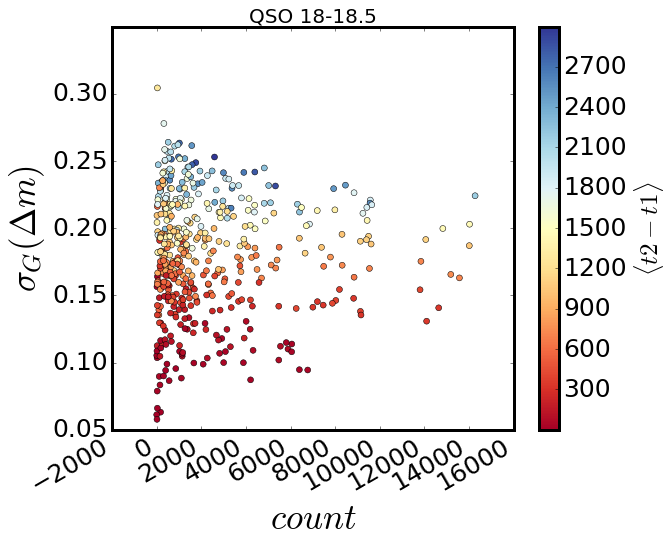

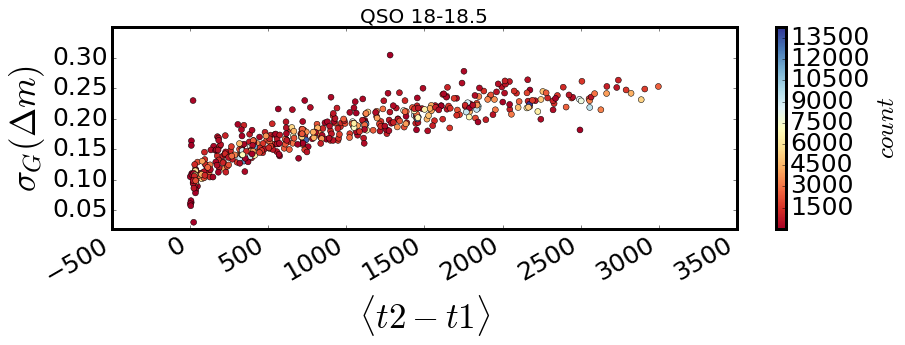

In [248]:

# Given three pieces of information per bin : 
# sigmaG(delta_mag) ,   mean(t2-t1)  , count ,
# can plot x vs y, and color by z  

fig,ax = plt.subplots(1,1, figsize=(9,8))
cm = plt.cm.get_cmap('RdYlBu')
sc = ax.scatter(z_count, z_sigmaG, lw=0.5, c =z_t2t1 , s=35, cmap = cm )
cbar = plt.colorbar(sc)
cbar.set_label(r'$\langle t2-t1 \rangle$', fontsize=25)

fig.autofmt_xdate()
ax.set_title( pre[obj]+ ' '+str(Min)+'-'+str(Min+0.5), fontsize=20)
ax.set_xlabel(r'$count$')
ax.set_ylabel(r'$\sigma_{G}(\Delta m)$')
ax.set_ylim(0.05, 0.35)
#ax.set_xlim(-100, )
title = pre[obj]+'_'+str(Min)+'-'+str(Max)+'_sigmaG-count_bins_'+str(bin_size_days)+'_days.png'
plt.savefig(outDir +title, bbox_inches = 'tight')
plt.show()



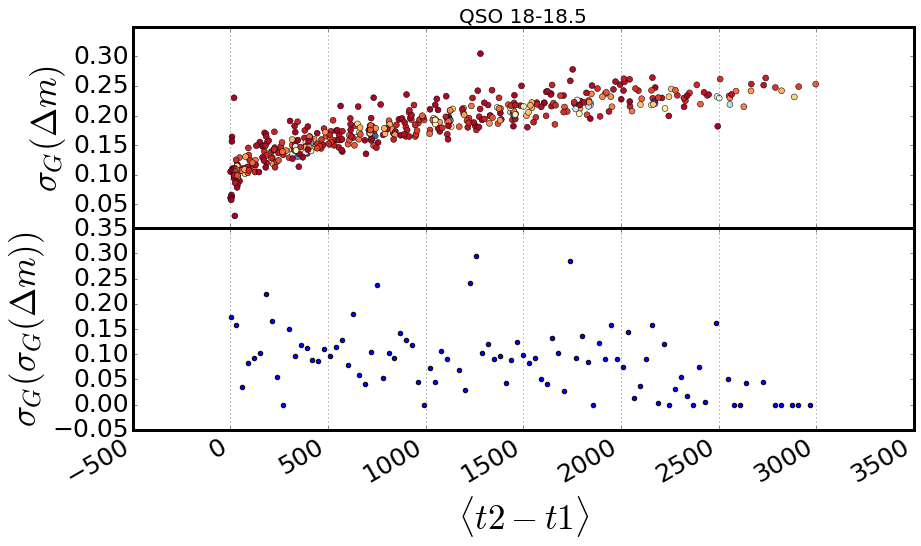

In [249]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binned_statistic.html 
from scipy.stats import binned_statistic


bins = 100

mask_nans = np.bitwise_not(np.isnan(z_t2t1))

sigmaG = lambda x : 0.7413 *(np.percentile(x,75) - np.percentile(x,25))
stats = binned_statistic(z_t2t1[mask_nans], z_sigmaG[mask_nans], statistic=sigmaG, bins=bins)
mean_sigmaG = stats[0]
xedges = stats[1]

fig,(ax1,ax2) = plt.subplots(2,1, figsize=(14,8), sharex=True)
sc = ax1.scatter(z_t2t1, z_sigmaG, lw=0.5, c = z_count, s=35, cmap=cm)
#cbar = plt.colorbar(sc)
#cbar.set_label(r'$ count $', fontsize=25)


ax2.set_xlabel(r'$\langle t2-t1  \rangle $')
ax1.set_ylabel(r'$\sigma_{G}(\Delta m)$')
ax1.set_ylim(0.01, 0.35)
ax1.set_title(pre[obj]+' '+str(Min)+'-'+str(Min+0.5), fontsize=20)

fig.autofmt_xdate()

ax2.scatter(xedges[:-1], 10*mean_sigmaG)

fig.subplots_adjust(hspace=0)
ax1.grid(axis='x')
ax2.grid(axis='x')
ax2.set_ylabel(r'$\sigma_{G}(\sigma_{G}(\Delta m))$')
#ax2.set_ylim(0.05, 0.8)
title = pre[obj]+'_'+str(Min)+'-'+str(Max)+'_two_panels_'+str(bin_size_days)+'-days_'+str(bins)+'-bins.png'
plt.savefig(outDir +title, bbox_inches = 'tight')

In [245]:
Max

18.5

### Histograms of $\chi$ and $\sigma_{G}$, for quasars and stars in narrow range of $\tau$


Using magnitude range   17.00 < mag < 18.00

Using data for   660.693 < tau < 794.328 [days]

Using data for   851.138 < tau < 1000.000 [days]

Using magnitude range   18.00 < mag < 18.50

Using data for   660.693 < tau < 794.328 [days]

Using data for   851.138 < tau < 1000.000 [days]

Using magnitude range   18.50 < mag < 19.00

Using data for   660.693 < tau < 794.328 [days]

Using data for   851.138 < tau < 1000.000 [days]
saving plot to: /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-03-24/Fig_3_histogram_panels.png


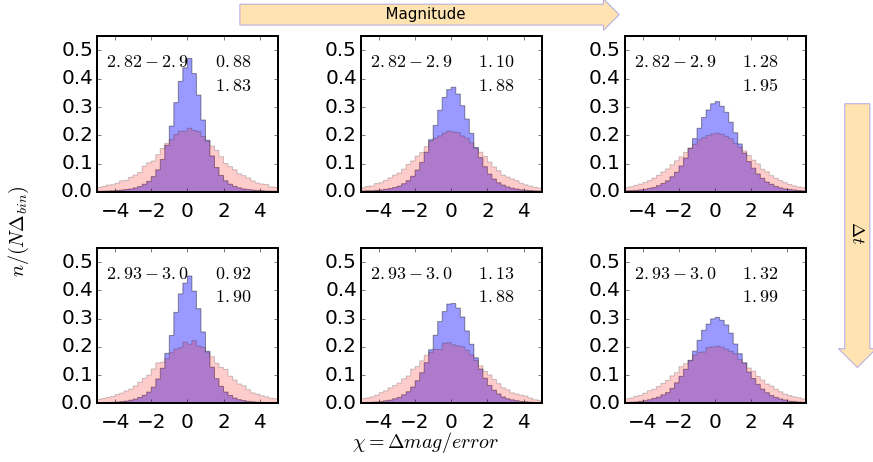

In [277]:
# So we want to lump red and blue stars together ,  and 
# quasars separately... 

#Define function used to plot each histogram in the grid ... 

# Use data from another day : 
#outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_3_data/2016-06-07/')

from matplotlib import rcParams

rcParams['ytick.labelsize'] = 20
rcParams['xtick.labelsize'] = 20
#rcParams['axes.labelsize'] = 35
axes_label_font = 20 
#rcParams['font.size'] = 25
axes_text_size = 18
rcParams['axes.linewidth'] = 2
rcParams.update({'figure.autolayout': False})

def plot2Chistograms(chiQSO, chiSTAR, Xmin, Xmax, Ymin, Ymax, ax, bins=20, 
                     title='', axes_text_size=25):
    limits = [(Xmin, Xmax, Ymin, Ymax)]
    ax.set_xlim(Xmin, Xmax)
    ax.set_ylim(Ymin, Ymax)        
        
    #plt.tick_params(axis='both', which='major', labelsize=15)
    xTitle = Xmin + 0.05*(Xmax-Xmin)
    yTitle = Ymax - 0.2*(Ymax-Ymin)
    ax.text(xTitle, yTitle, title, fontsize=axes_text_size) # , fontsize=12 

    # plot a histogram
    ax.hist(chiSTAR, bins=bins, normed=True, facecolor='blue', histtype='stepfilled', alpha=0.4)
    ax.hist(chiQSO, bins=bins, normed=True, facecolor='red', histtype='stepfilled', alpha=0.2)

    # plot the robust width of both distributions
    stdev_rob_QSO = 0.7414 *(np.percentile(chiQSO,75) - np.percentile(chiQSO,25) )
    stdev_rob_S = 0.7414 *(np.percentile(chiSTAR,75) - np.percentile(chiSTAR,25) )
    
    
    xTitle = Xmin + 0.65*(Xmax-Xmin)
    yTitle = Ymax - 0.2*(Ymax-Ymin)
    StarSigmaG = r'$'+str(stdev_rob_S)[:4]+'$'
    ax.text(xTitle, yTitle, StarSigmaG, fontsize=axes_text_size) #  fontsize=12
    
    
    xTitle = Xmin + 0.65*(Xmax-Xmin)
    yTitle = Ymax - 0.35*(Ymax-Ymin)
    QSOSigmaG = r'$'+str(stdev_rob_QSO)[:4]+'$'
    ax.text(xTitle, yTitle, QSOSigmaG, fontsize=axes_text_size) #  fontsize=12
    
    ax.tick_params(axis='x', pad=10)
    


%matplotlib inline
fig, axs = plt.subplots(2,3, figsize=(12,6))
    
# initiate a storage array for the robust widths of chi distributions ... 
store_fc_starB = np.zeros((3,4))

Min_arr = [17, 18, 18.5]
Max_arr = [18, 18.5, 19]

tau_min_arr = [np.power(10,tau) for tau in [2.82, 2.93] ]
tau_max_arr = [np.power(10,tau) for tau in [2.9, 3.0] ]

xlims_arr = [5,5]

for j in range(len(Min_arr) ):
    
    Min = Min_arr[j]
    Max = Max_arr[j] 
    print('\nUsing magnitude range   %.2f < mag < %.2f' %(Min,Max))
    for k in range(len(tau_max_arr)): 
        
        tau_min = tau_min_arr[k]
        tau_max = tau_max_arr[k]

        print('\nUsing data for   %.3f < tau < %.3f [days]'% (tau_min, tau_max))
            
        # stars blue 
        mask_in = (tau_min < out_dic[Min]['starsB'][1]) * (out_dic[Min]['starsB'][1] < tau_max)
        xi = out_dic[Min]['starsB'][0][mask_in]
        ei = out_dic[Min]['starsB'][2][mask_in]
        chiS = xi / ei 
        chiSok = chiS[np.abs(chiS)<5]
        
        # calculate the robust width of the chi distribution .... 
        stdev_rob_S = 0.7414 *(np.percentile(chiSok,75) - np.percentile(chiSok,25) )
        
        # quasars 
        mask_in = (tau_min < out_dic[Min]['qso'][1]) * (out_dic[Min]['qso'][1] < tau_max)
        xi = out_dic[Min]['qso'][0][mask_in]
        ei = out_dic[Min]['qso'][2][mask_in]
        chiQ = xi / ei 
        chiQok = chiQ[np.abs(chiQ)<xlims_arr[k]]

        # plot histograms
        Xmin = -xlims_arr[k]
        Xmax = xlims_arr[k]
        bins = 40 
        title= r'$ '+' '+ str(np.log10(tau_min))+'-'+str(np.log10(tau_max))+'$'
        row  = k
        col = j 
        plot2Chistograms(chiQok, chiSok, Xmin=Xmin, Xmax=Xmax, Ymin=0.0, 
                             Ymax=0.55, ax=axs[row,col],bins=bins,  
                         title=title, axes_text_size=axes_text_size)
        
        # save the value of robust width of stellar chi distribution...
        stdev_rob_S = 0.7414 *(np.percentile(chiSok,75) - np.percentile(chiSok,25) )
        #store_fc_starB[row,column] = [magnitude_max, deltaTrange]
        store_fc_starB[j,k] = stdev_rob_S
        
Xlabel = '$\chi = \Delta mag / error$'
Ylabel = '$n / (N\Delta_{bin})$'
fig.text(0.5, 0.01, Xlabel, ha='center', va='center', fontsize=axes_label_font)
fig.text(0.03, 0.5, Ylabel, ha='center', va='center', rotation='vertical', fontsize=axes_label_font)


# add two arrows to guide eyes 
bbox_props = dict(boxstyle="rarrow,pad=0.2", fc="orange", ec="b", alpha=0.3, lw=1, clip_on = False)

n_spaces = 30 
t = fig.text(0.5, 1.0, n_spaces*' '+'Magnitude'+n_spaces*' ', ha="center", va="center", rotation=0, size=15, bbox=bbox_props)

n_spaces = 20 
t = fig.text(1.0,0.5 , n_spaces*' '+'$\Delta t$'+n_spaces*' ', ha="center", va="center", rotation=-90, 
             size=18, bbox=bbox_props)




#name = 'poster_r_cut_qso_starsB_histogram_grid.png'
#name = None
name = outDir+'Fig_3_histogram_panels.png'
if (name is None):
    plt.show() 
else:
    print('saving plot to: %s'%name)
    fig.subplots_adjust(wspace=0.46, hspace=0.36, left=0.12, right=0.94, bottom=0.10, top=0.95)
    plt.savefig(name, bbox_inches='tight')
    
plt.savefig(outDir + 'Fig_3_x-Mag_y_tau_chi_histograms.png', bbox_inches = 'tight')

In [47]:
# check that the two are the same ...
Min = 18
Max = 18.5
tau_min = tau_min_arr[0]
tau_max = tau_max_arr[0]

fname1 = outDir + 'QSO_'+str(Min)+'-'+str(Max)+'_tau_'+str(tau_min)[:5]+'-'+str(tau_max)[:5]+'_days.txt'
file1 = np.loadtxt(fname1)

fname2  = outDir + 'detail_QSO_'+str(Min)+'-'+str(Max)+'_tau_'+str(tau_min)[:5]+'-'+str(tau_max)[:5]+'_days.txt'
file2 = np.loadtxt(fname2)

x1 = file1[:,1]

x2 = file2[:,1]


Using magnitude range   17.00 < mag < 18.00

Using data for   660.693 < tau < 794.328 [days]


KeyError: 17

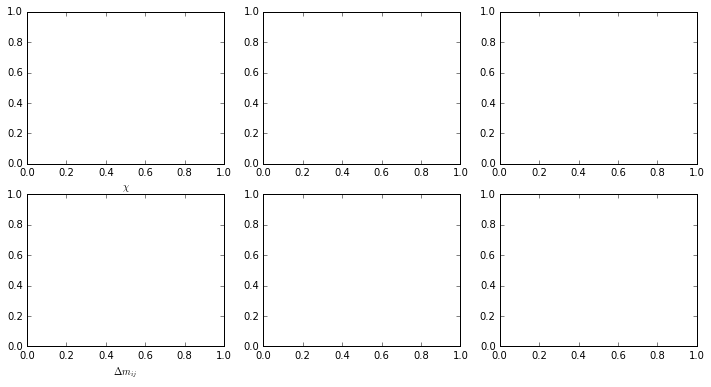

In [23]:
# Make the stellar plot ...

%matplotlib inline
fig, axs = plt.subplots(2,3, figsize=(12,6))
    
Min_arr = [17, 18, 18.5]
Max_arr = [18, 18.5, 19]

tau_min_arr = [np.power(10,tau) for tau in [2.82, 2.93] ]
tau_max_arr = [np.power(10,tau) for tau in [2.9, 3.0] ]
sample_colors = ['green', 'orange']
alphas = [0.4,0.4]

  # one for chi, the other for sigmaG dist.   

objects = 'stars' # qso' # 'stars'

if objects == 'qso':
    xlims_arr = [10,1]
else : 
    xlims_arr = [5,1]
    
for j in range(len(Min_arr) ):
    
    Min = Min_arr[j]
    Max = Max_arr[j] 
    print('\nUsing magnitude range   %.2f < mag < %.2f' %(Min,Max))
    
    axs[0,j].set_xlabel(r'$\chi$')
    axs[1,j].set_xlabel(r'$\Delta m_{ij}$')
    # plot the two samples (minimum and maximum )
    for k in range(len(tau_max_arr)): 
        
        tau_min = tau_min_arr[k]
        tau_max = tau_max_arr[k]
        hist_color = sample_colors[k]
        print('\nUsing data for   %.3f < tau < %.3f [days]'% (tau_min, tau_max))
        
        if objects == 'stars' : 
            # collect points for this sample :
            # blue stars
            obj = 'starsB'
            mask_in = (tau_min < out_dic[Min][obj][1]) * (out_dic[Min][obj][1] < tau_max)
            xi = out_dic[Min][obj][0][mask_in]
            ei = out_dic[Min][obj][2][mask_in]

            # append red stars
            obj = 'starsR'
            mask_in = (tau_min < out_dic[Min][obj][1]) * (out_dic[Min][obj][1] < tau_max)
            xi = np.append(xi, out_dic[Min][obj][0][mask_in])
            ei = np.append(ei, out_dic[Min][obj][2][mask_in])
            
        if objects == 'qso' : 
            mask_in = (tau_min < out_dic[Min]['qso'][1]) * (out_dic[Min]['qso'][1] < tau_max)
            xi = out_dic[Min]['qso'][0][mask_in]
            ei = out_dic[Min]['qso'][2][mask_in]
        
        chi = xi / ei

        ###########################
        # top row : plot chi distribution 
        ###########################
        row = 0
        col = j
        
        ax = axs[row,col]
        
        Xmin = -xlims_arr[row]
        Xmax = xlims_arr[row]
        
        if objects  == 'qso' : 
            Ymin, Ymax = 0, 0.3
        else:
            Ymin, Ymax = 0, 0.55
            
        axs[row,col].set_xlim(Xmin, Xmax)
        axs[row,col].set_ylim(Ymin, Ymax)  
        
        # define what we are plotting ....
        sample = chi[np.abs(chi)<xlims_arr[row]]
          
        # plot histogram 
        bins=40
        hist = ax.hist(sample, bins=bins, normed=True, facecolor=hist_color, histtype='stepfilled', alpha=alphas[k])
        
        # display the text with  the robust width  of  the  distribution
        stdev_rob = 0.7414 *(np.percentile(sample,75) - np.percentile(sample,25) )
    
        if k == 0 : 
            frac = 0.2
        elif k == 1 : 
            frac = 0.35

        xTitle = Xmin + 0.65*(Xmax-Xmin)
        yTitle = Ymax - frac*(Ymax-Ymin)
        sigmaG = r'$'+str(stdev_rob)[:4]+'$'
        ax.text(xTitle, yTitle, sigmaG, fontsize=axes_text_size, color=hist_color) 
        ax.tick_params(axis='x', pad=5)
        
    
        ###########################
        # bottom row : plot sigmaG distribution 
        ###########################
        row = 1
        col = j
        ax = axs[row,col]
    
        Xmin, Xmax = -xlims_arr[row],xlims_arr[row]
        Ymin, Ymax = 0, 3.2
        axs[row,col].set_xlim(Xmin, Xmax)
        axs[row,col].set_ylim(Ymin, Ymax)  
    
        # define what we are plotting ....
        sample = xi[np.abs(xi)<xlims_arr[row]]
        # plot histogram 
        bins=40
        hist = ax.hist(sample, bins=bins, normed=True, facecolor=hist_color, histtype='stepfilled', alpha=alphas[k])
        
        # display the text with  the robust width  of  the  distribution
        stdev_rob = 0.7414 *(np.percentile(sample,75) - np.percentile(sample,25) )
    
        if k == 0 : 
            frac = 0.2
        elif k == 1 : 
            frac = 0.35

        xTitle = Xmin + 0.65*(Xmax-Xmin)
        yTitle = Ymax - frac*(Ymax-Ymin)
        sigmaG = r'$'+str(stdev_rob)[:4]+'$'
        ax.text(xTitle, yTitle, sigmaG, fontsize=axes_text_size, color=hist_color) 
        
        xTitle = Xmin + 0.05*(Xmax-Xmin)
        yTitle = Ymax - frac*(Ymax-Ymin)
        title = r'$'+str(len(sample))+'$'
        ax.text(xTitle, yTitle, title, fontsize=axes_text_size,color=hist_color) # , fontsize=12 
        
        ax.tick_params(axis='x', pad=5)
fig.subplots_adjust(hspace=0.4)
Ylabel = '$n / (N\Delta_{bin})$'
fig.text(0.03, 0.5, Ylabel, ha='center', va='center', rotation='vertical', fontsize=axes_label_font)


# add two arrows to guide eyes 
bbox_props = dict(boxstyle="rarrow,pad=0.2", fc="orange", ec="b", alpha=0.3, lw=1, clip_on = False)

n_spaces = 30 
t = fig.text(0.5, 1.0, n_spaces*' '+'Magnitude'+n_spaces*' ', ha="center", va="center", rotation=0, size=15, bbox=bbox_props)

#plt.legend(handles, ['min', 'max'], bbox_to_anchor=(2, 0),loc = 'lower right')

fig.subplots_adjust(wspace=0.3)
plt.savefig(outDir + 'Fig_3_x-Mag_sigG_chi_histograms_'+objects+'.png', bbox_inches = 'tight')



In [382]:
objects

'qso'